In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Data

The data sets are already standardized with the `data/clean01.py` and `data/clean02.py` scripts so
whichever operation we can do on one data set, we can do on the other.

Genshin Impact, being the wonderful game that it is, has decided that it is going to have three types
of banners players can pull from. Thus, I am going to analyze them separately because _I do be eager
like that_.


## Data Format

I am going to skip the format of the original data set because it is irrelevant to this notebook.

The rows of the data sets are as following:

- **Rarity**: how many stars the character/weapon is classified as
- **Date**: date of the pull
- **Time**: time of the pull
- **Banner**: type of banner, described as following:
  - _200_: Permanent banner, always available to players
  - _301_ and _400_: Limited character banner, changes every now and then
  - _302_: Limited weapon banner, changes every now and then
- **Type**: drop type, either character or weapon
  - This attribute might interfere with our model so it might be dropped later on


In [2]:
from datetime import date, timedelta


def simplify_dt(given_dt: str):
    given_date, given_time = given_dt.split(' ')
    yr, mo, da = map(int, given_date.split('-'))
    hr, mi, _ = map(int, given_time.split(':'))

    pull_time = hr + round(mi / 60)
    pull_date = date(yr, mo, da) + timedelta(pull_time // 24)

    return pull_date, pull_time % 24


data_set01 = pd.read_csv("data/data01.csv")
data_set02 = pd.read_csv("data/data02.csv")
full_df = pd.concat([
    data_set01,
    data_set02,
]).reset_index().drop(["Type", "index"], axis=1)
full_df["DateTime"] = full_df["DateTime"].apply(simplify_dt)
full_df.sort_values("DateTime")

print(full_df.shape)
full_df.sample(5)


(9672437, 3)


,Rarity,DateTime,Banner
1751537,3,"(2021-09-01, 10)",301
6497934,3,"(2022-02-03, 18)",301
5223224,4,"(2022-03-31, 10)",200
7621322,3,"(2022-02-16, 11)",301
6597744,4,"(2021-09-09, 12)",301


# Reusable Code for Analysis

These are just some constants and functions used for analyzing the data.


## Constants


In [3]:
RELEASE_DATE = date(2020, 9, 28)
LAST_DAY_DATA = date(2022, 7, 26)
DAYS_SINCE_RELEASE = (LAST_DAY_DATA - RELEASE_DATE).days + 1


## Functions used to transform the data


In [4]:
def transform_rarity(banner: pd.DataFrame, cond_series: pd.Series, dimension: tuple[int, int]):
    grouped_counts = banner[cond_series]\
        .groupby("DateTime")\
        .count()

    ret_matrix = np.zeros(dimension)
    for i, key in enumerate(grouped_counts.index):
        d, t = key
        ret_matrix[t, d] = grouped_counts.iloc[i]

    return ret_matrix


def transform_func(banner: pd.DataFrame, date_transformer: callable, dimension: tuple[int, int]):
    banner = banner.drop("Banner", axis=1)
    banner["DateTime"] = banner["DateTime"].map(date_transformer)

    total = transform_rarity(banner, banner.Rarity != 0, dimension)
    five_stars = transform_rarity(banner, banner.Rarity == 5, dimension)
    four_stars = transform_rarity(banner, banner.Rarity == 4, dimension)

    return [total, five_stars / (total + 1), four_stars / (total + 1)]


def first_doy(d): return date(d.year, 1, 1)


def dow_transformer(dt): return dt[0].weekday(), dt[1]
def dom_transformer(dt): return dt[0].day - 1, dt[1]
def doy_transformer(dt): return (first_doy(dt[0]) - dt[0]).days, dt[1]
def dsr_transformer(dt): return (dt[0] - RELEASE_DATE).days, dt[1]


## Functions used to visualize the data


In [5]:
def dow_heatmap(data: np.ndarray, ax: plt.Axes, title: str):
    row_label = np.arange(0, 24)
    col_label = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

    d_min = np.min(data)
    d_max = np.max(data)
    sns.heatmap(data, yticklabels=row_label, xticklabels=col_label,
                vmin=d_min, vmax=d_max, ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Hour of day")
    ax.set_xlabel("Day of week")


def dom_heatmap(data: np.ndarray, ax: plt.Axes, title: str):
    row_label = np.arange(0, 24)
    col_label = np.arange(1, 32)

    d_min = np.min(data)
    d_max = np.max(data)
    sns.heatmap(data, yticklabels=row_label, xticklabels=col_label, ax=ax,
                vmin=d_min, vmax=d_max)
    ax.set_title(title)
    ax.set_ylabel("Hour of day")
    ax.set_xlabel("Day of month")


def doy_heatmap(data: np.ndarray, ax: plt.Axes):
    months = ["January", "February", "March", "April", "May", "June",
              "July", "August", "September", "October", "November", "December"]
    days_in_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    split_data = np.hsplit(data, np.cumsum(days_in_months))
    row_label = np.arange(0, 24)

    d_min = np.min(data)
    d_max = np.max(data)

    rows, cols = ax.shape
    for i in range(rows):
        for j in range(cols):
            idx_1d = i * rows + j
            split_col = np.arange(1, days_in_months[idx_1d] + 1)
            sns.heatmap(split_data[idx_1d], yticklabels=row_label, xticklabels=split_col,
                        ax=ax[i, j], vmin=d_min, vmax=d_max)
            ax[i, j].set_title(months[idx_1d])
            ax[i, j].set_ylabel("Hour of day")
            ax[i, j].set_xlabel("Day of year")


def dsr_heatmap(data: np.ndarray, axes, interval_name="Interval", day_label_offset=0):
    n = axes.size
    months = [f"{interval_name} {i + 1}" for i in range(n)]
    data = data[:, :n * (data.shape[1] // n - 1)]
    x_ticks = np.arange(0, data.shape[1]) - day_label_offset

    split_data = np.hsplit(data, n)
    split_col = np.hsplit(x_ticks, n)

    row_label = np.arange(0, 24)

    d_min = np.min(data)
    d_max = np.max(data)

    for i, cax in enumerate(axes):
        sns.heatmap(split_data[i], yticklabels=row_label,
                    xticklabels=split_col[i], ax=cax, vmin=d_min, vmax=d_max)
        cax.set_title(months[i])
        cax.set_ylabel("Hour of day")
        cax.set_xlabel("Days since release")


# First Try: _Raw data in different forms_


## Day of week


In [6]:
total_dow = transform_func(full_df, dow_transformer, (24, 7))
all_total, all_fives, all_fours = total_dow


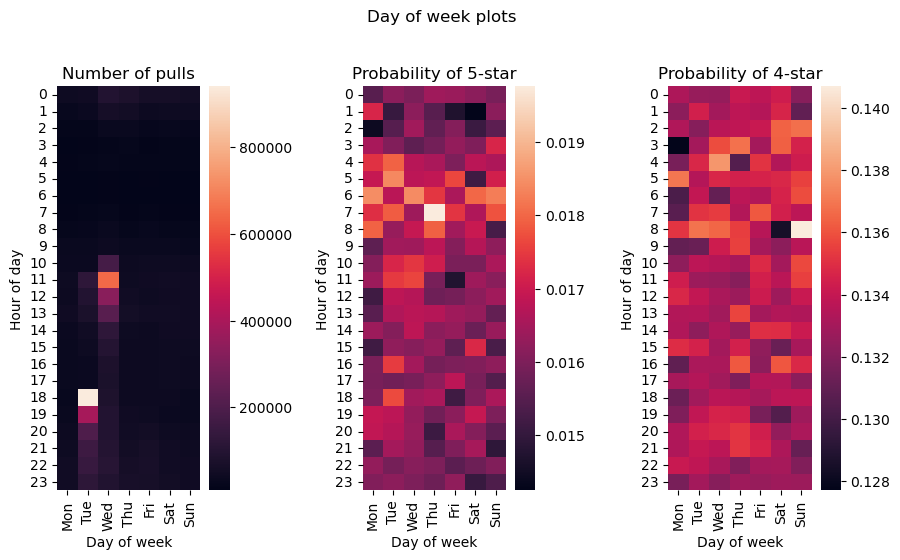

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
fig.tight_layout(pad=6.)
fig.suptitle("Day of week plots")

dow_heatmap(all_total, ax1, "Number of pulls")
dow_heatmap(all_fives, ax2, "Probability of 5-star")
dow_heatmap(all_fours, ax3, "Probability of 4-star")


## Day of month


In [8]:
total_dom = transform_func(full_df, dom_transformer, (24, 31))
all_dom, all_fives, all_fours = total_dom


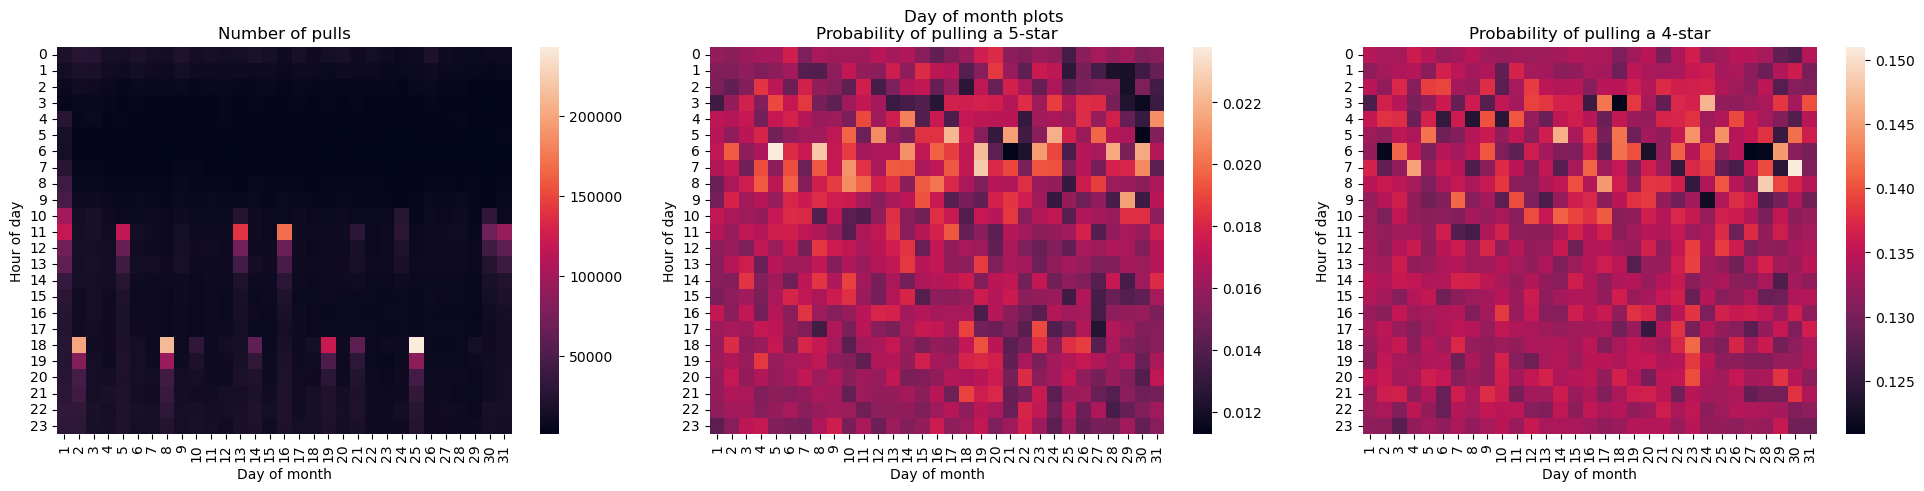

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=3.)
fig.suptitle("Day of month plots")

dom_heatmap(all_dom, ax1, "Number of pulls")
dom_heatmap(all_fives, ax2, "Probability of pulling a 5-star")
dom_heatmap(all_fours, ax3, "Probability of pulling a 4-star")


## Day of year


In [10]:
total_doy = transform_func(full_df, doy_transformer, (24, 365))
all_total, all_fives, all_fours = total_doy


In [11]:
YEAR_FIGSIZE = (26, 14)


### Pulls


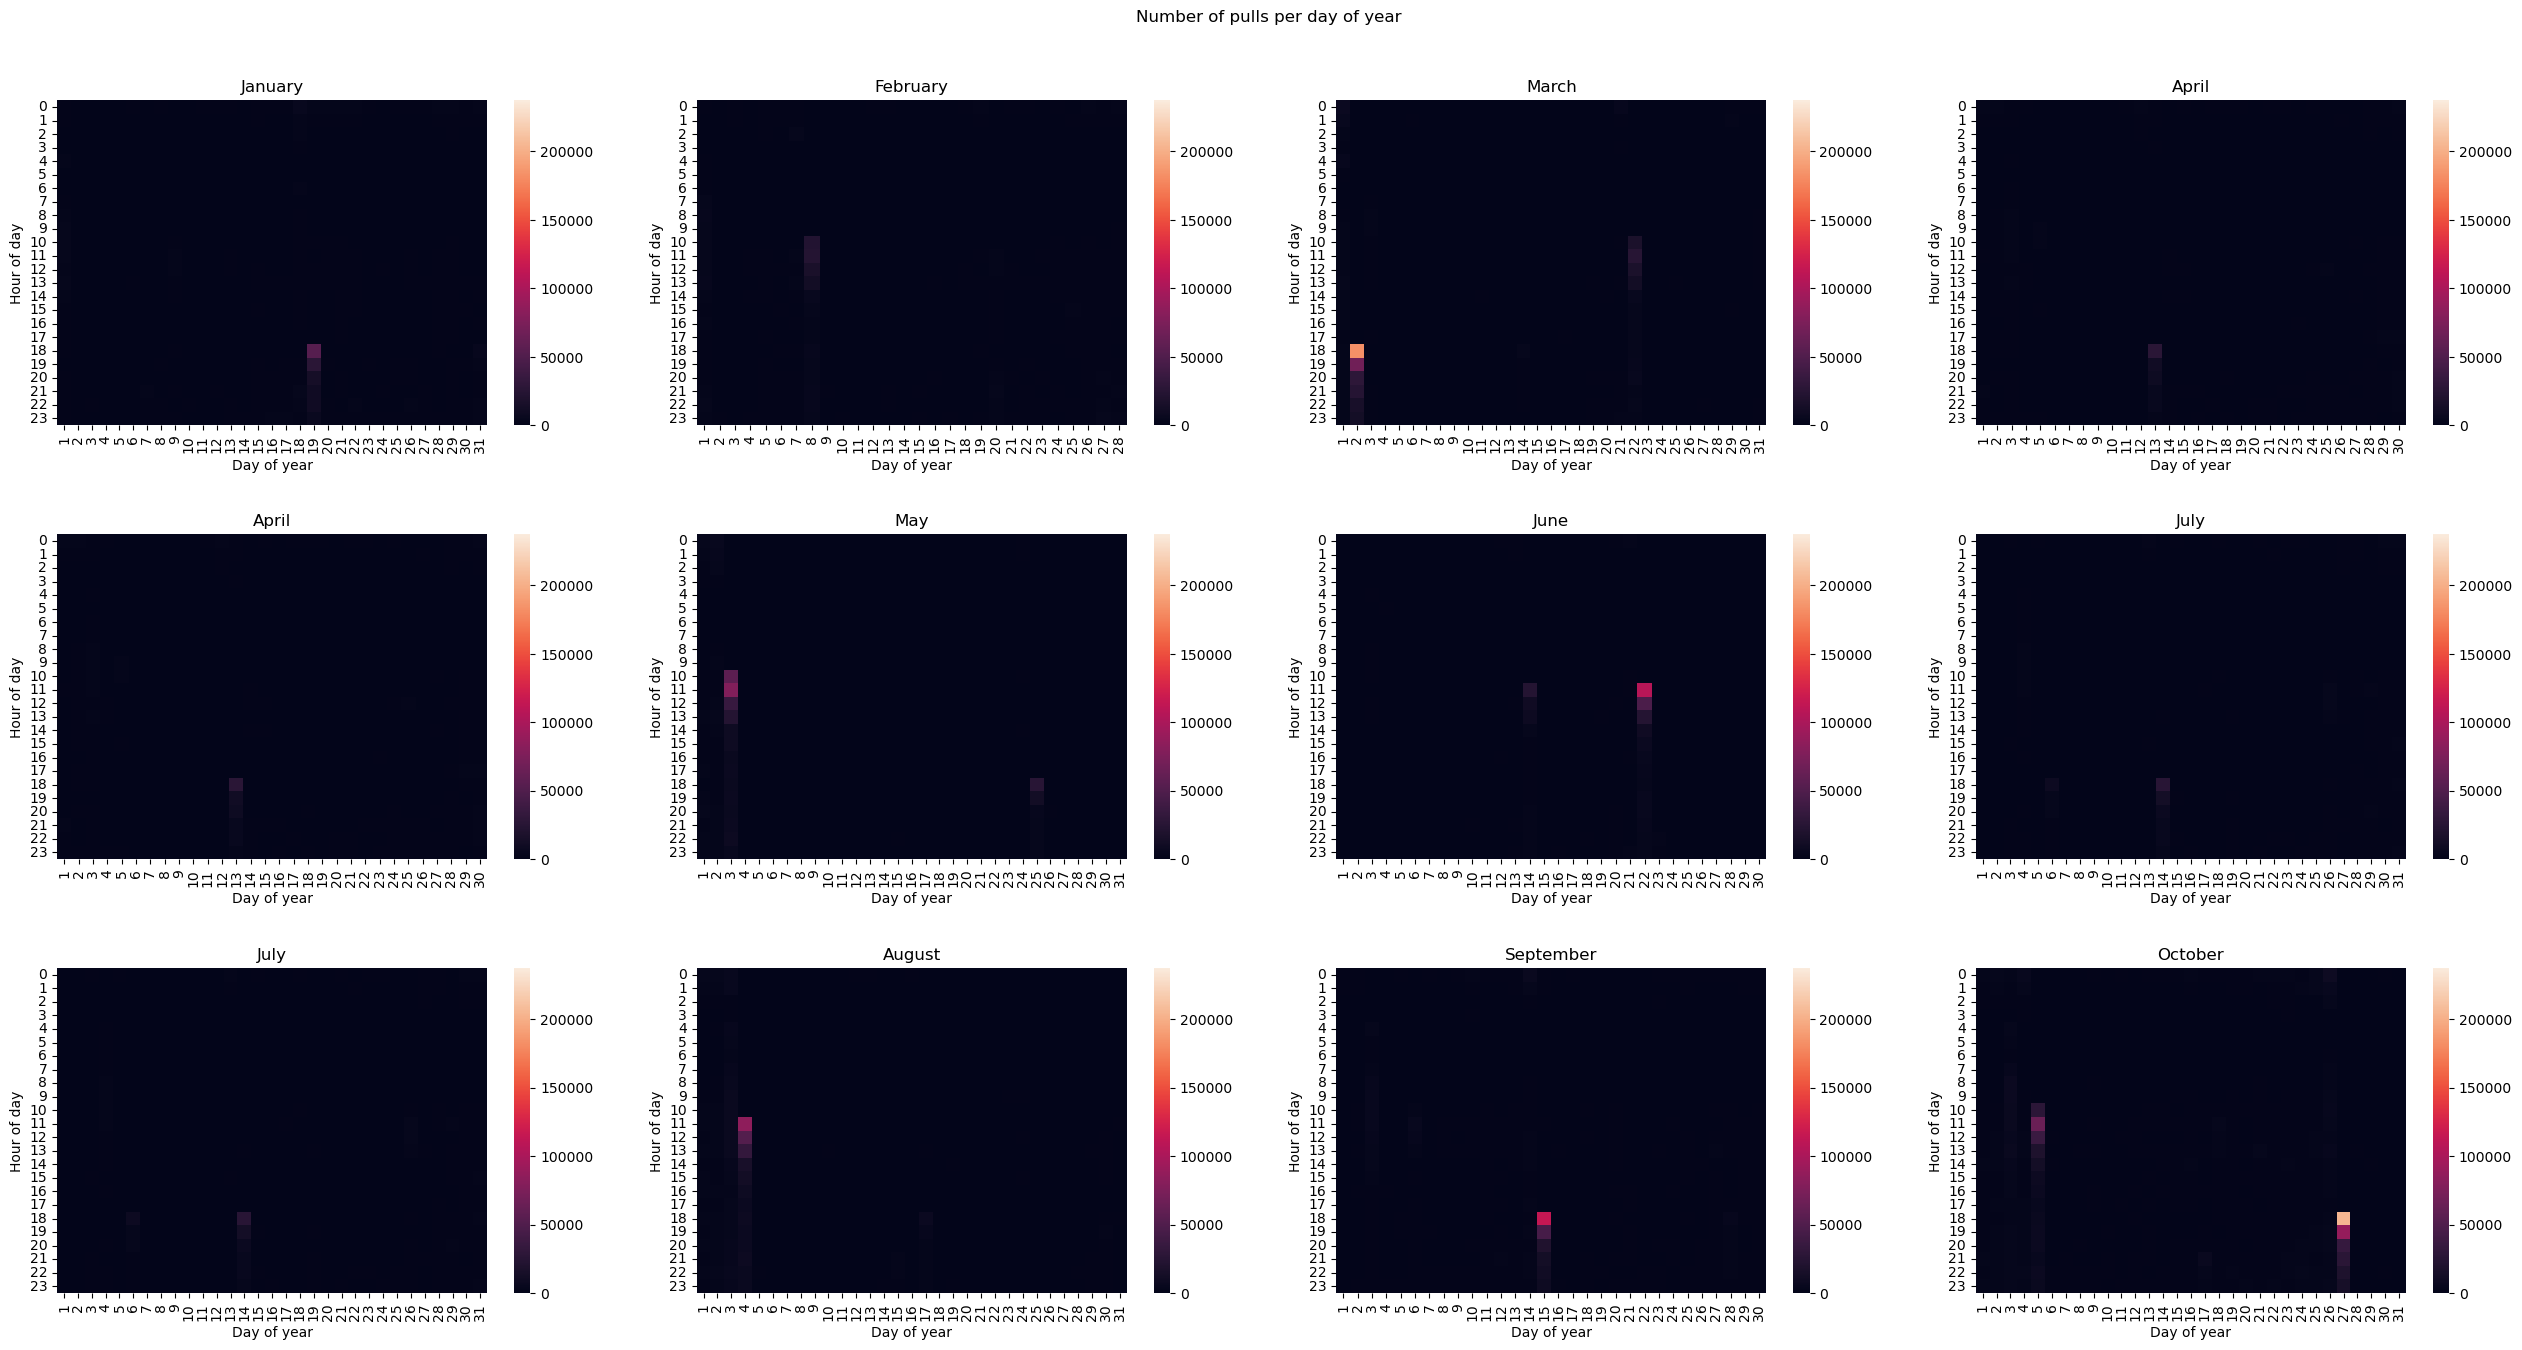

In [12]:
fig, axes = plt.subplots(3, 4, figsize=YEAR_FIGSIZE)
doy_heatmap(all_total, axes)
fig.suptitle("Number of pulls per day of year")
fig.tight_layout(pad=3.)


### 5-star


Text(0.5, 0.98, 'Probability of pulling a 5-star per day of year')

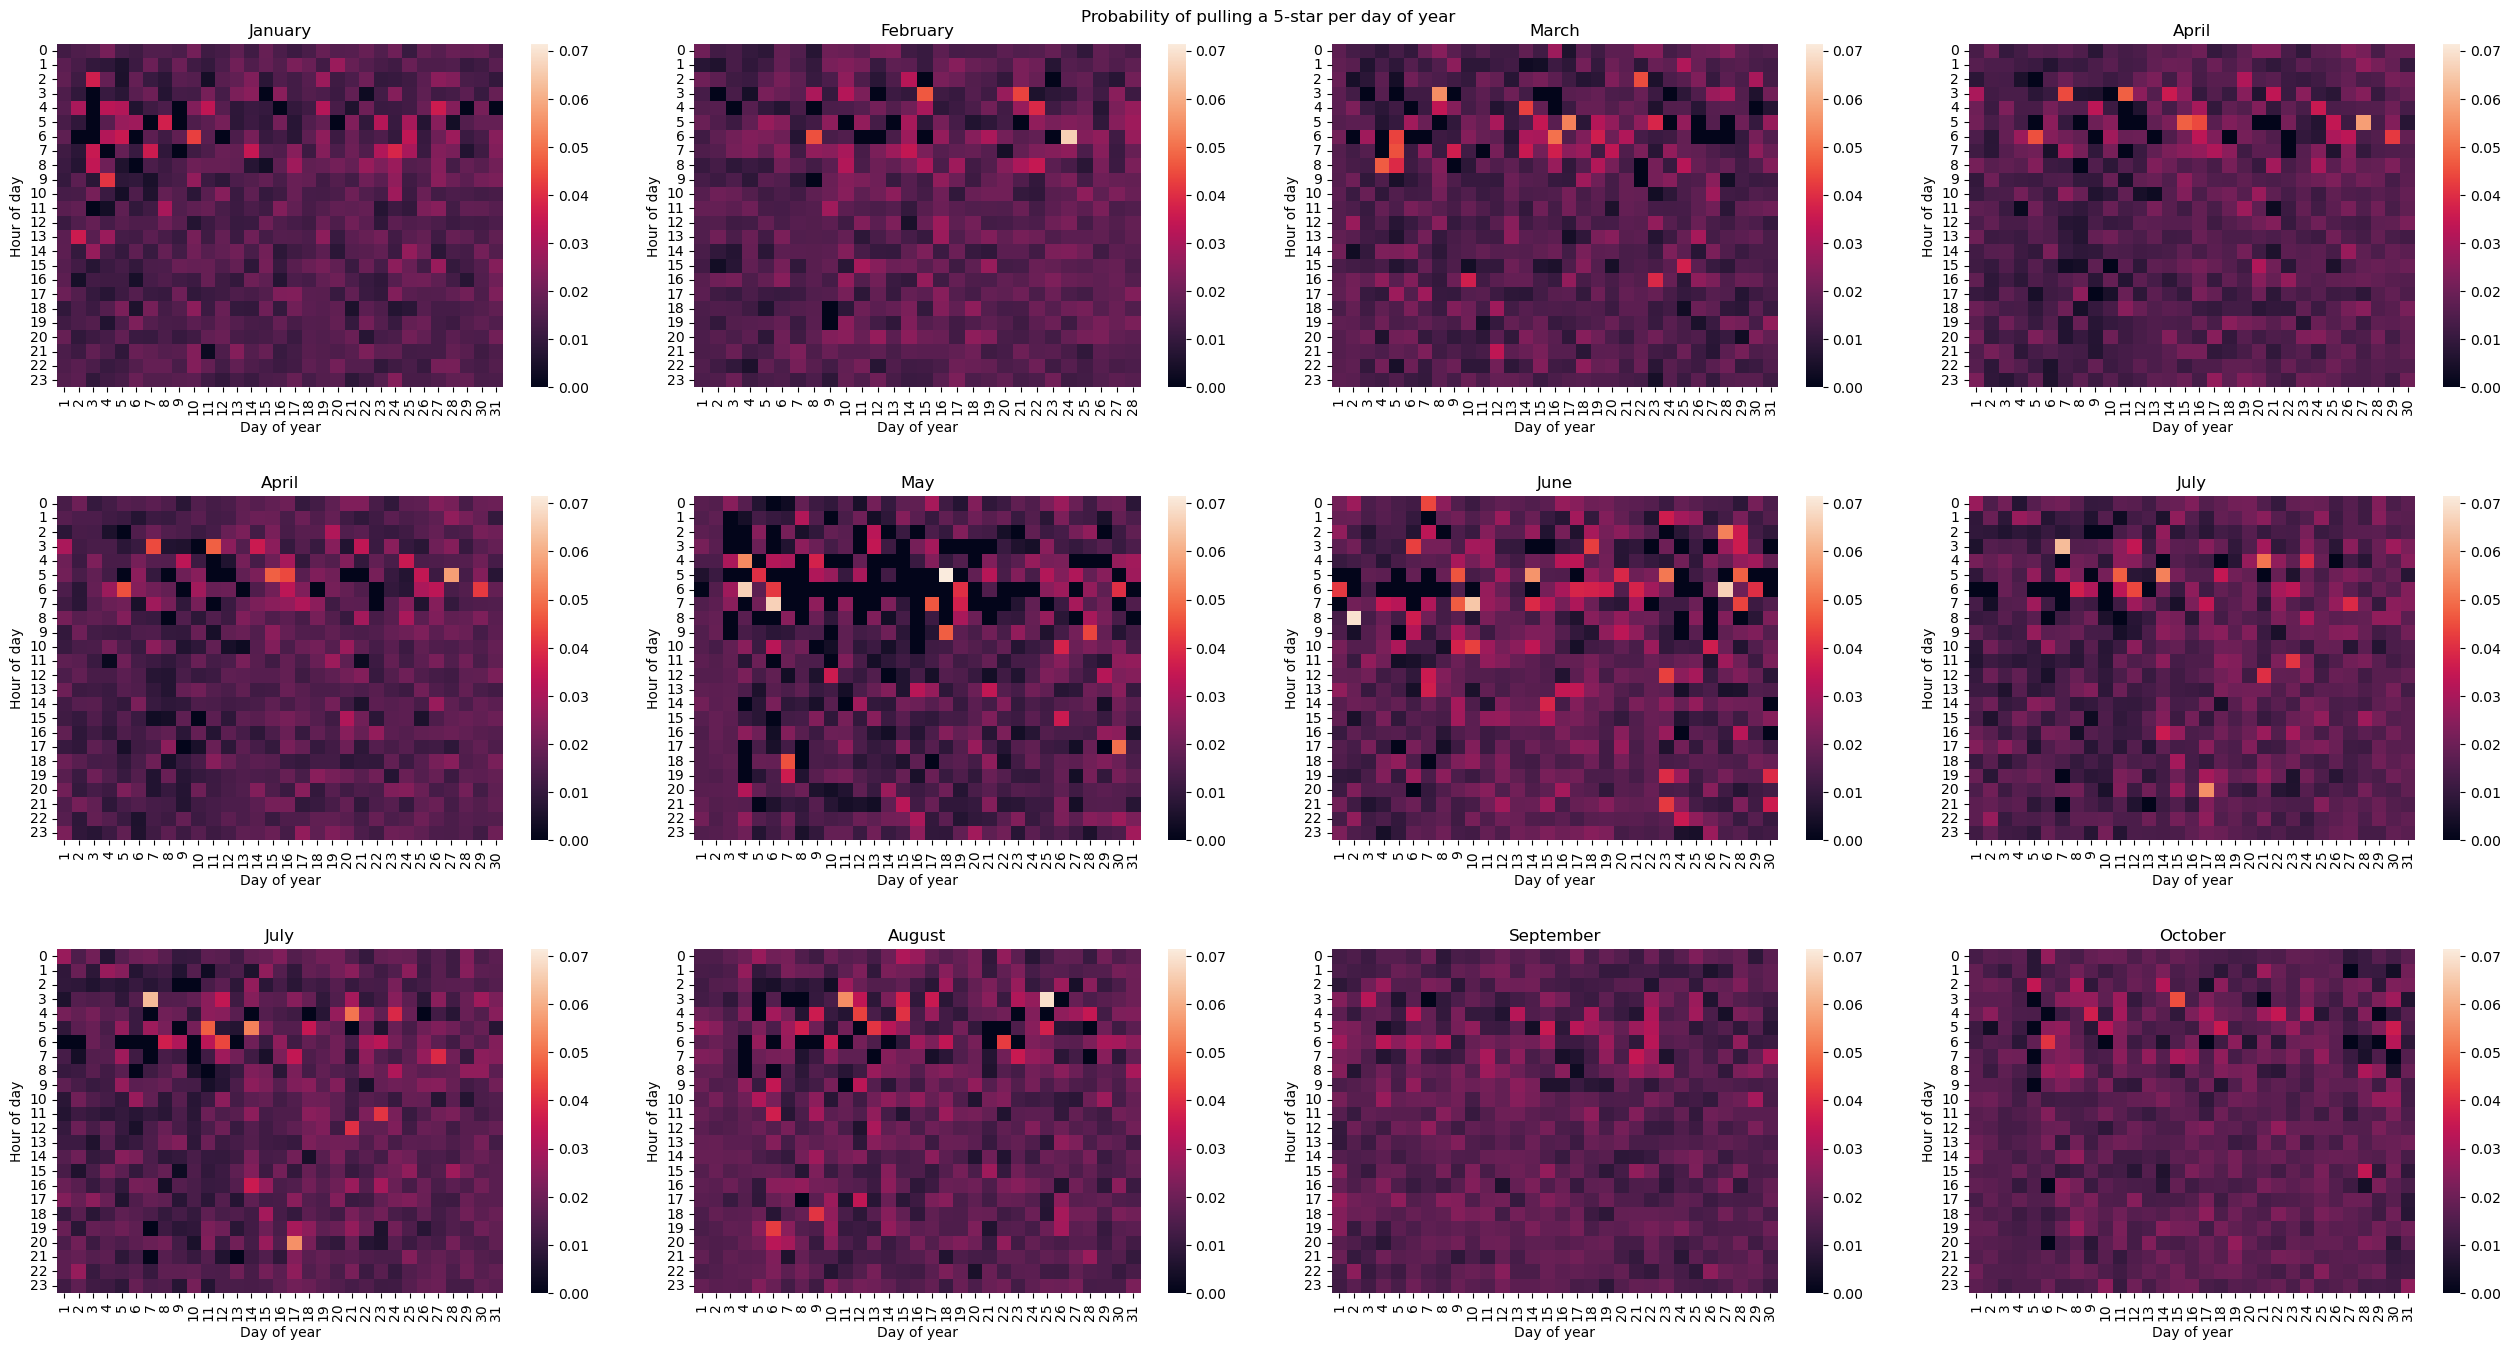

In [13]:
fig, axes = plt.subplots(3, 4, figsize=YEAR_FIGSIZE)
doy_heatmap(all_fives, axes)
fig.tight_layout(pad=3.)
fig.suptitle("Probability of pulling a 5-star per day of year")


### 4-star


Text(0.5, 0.98, 'Probability of pulling a 4-star per day of year')

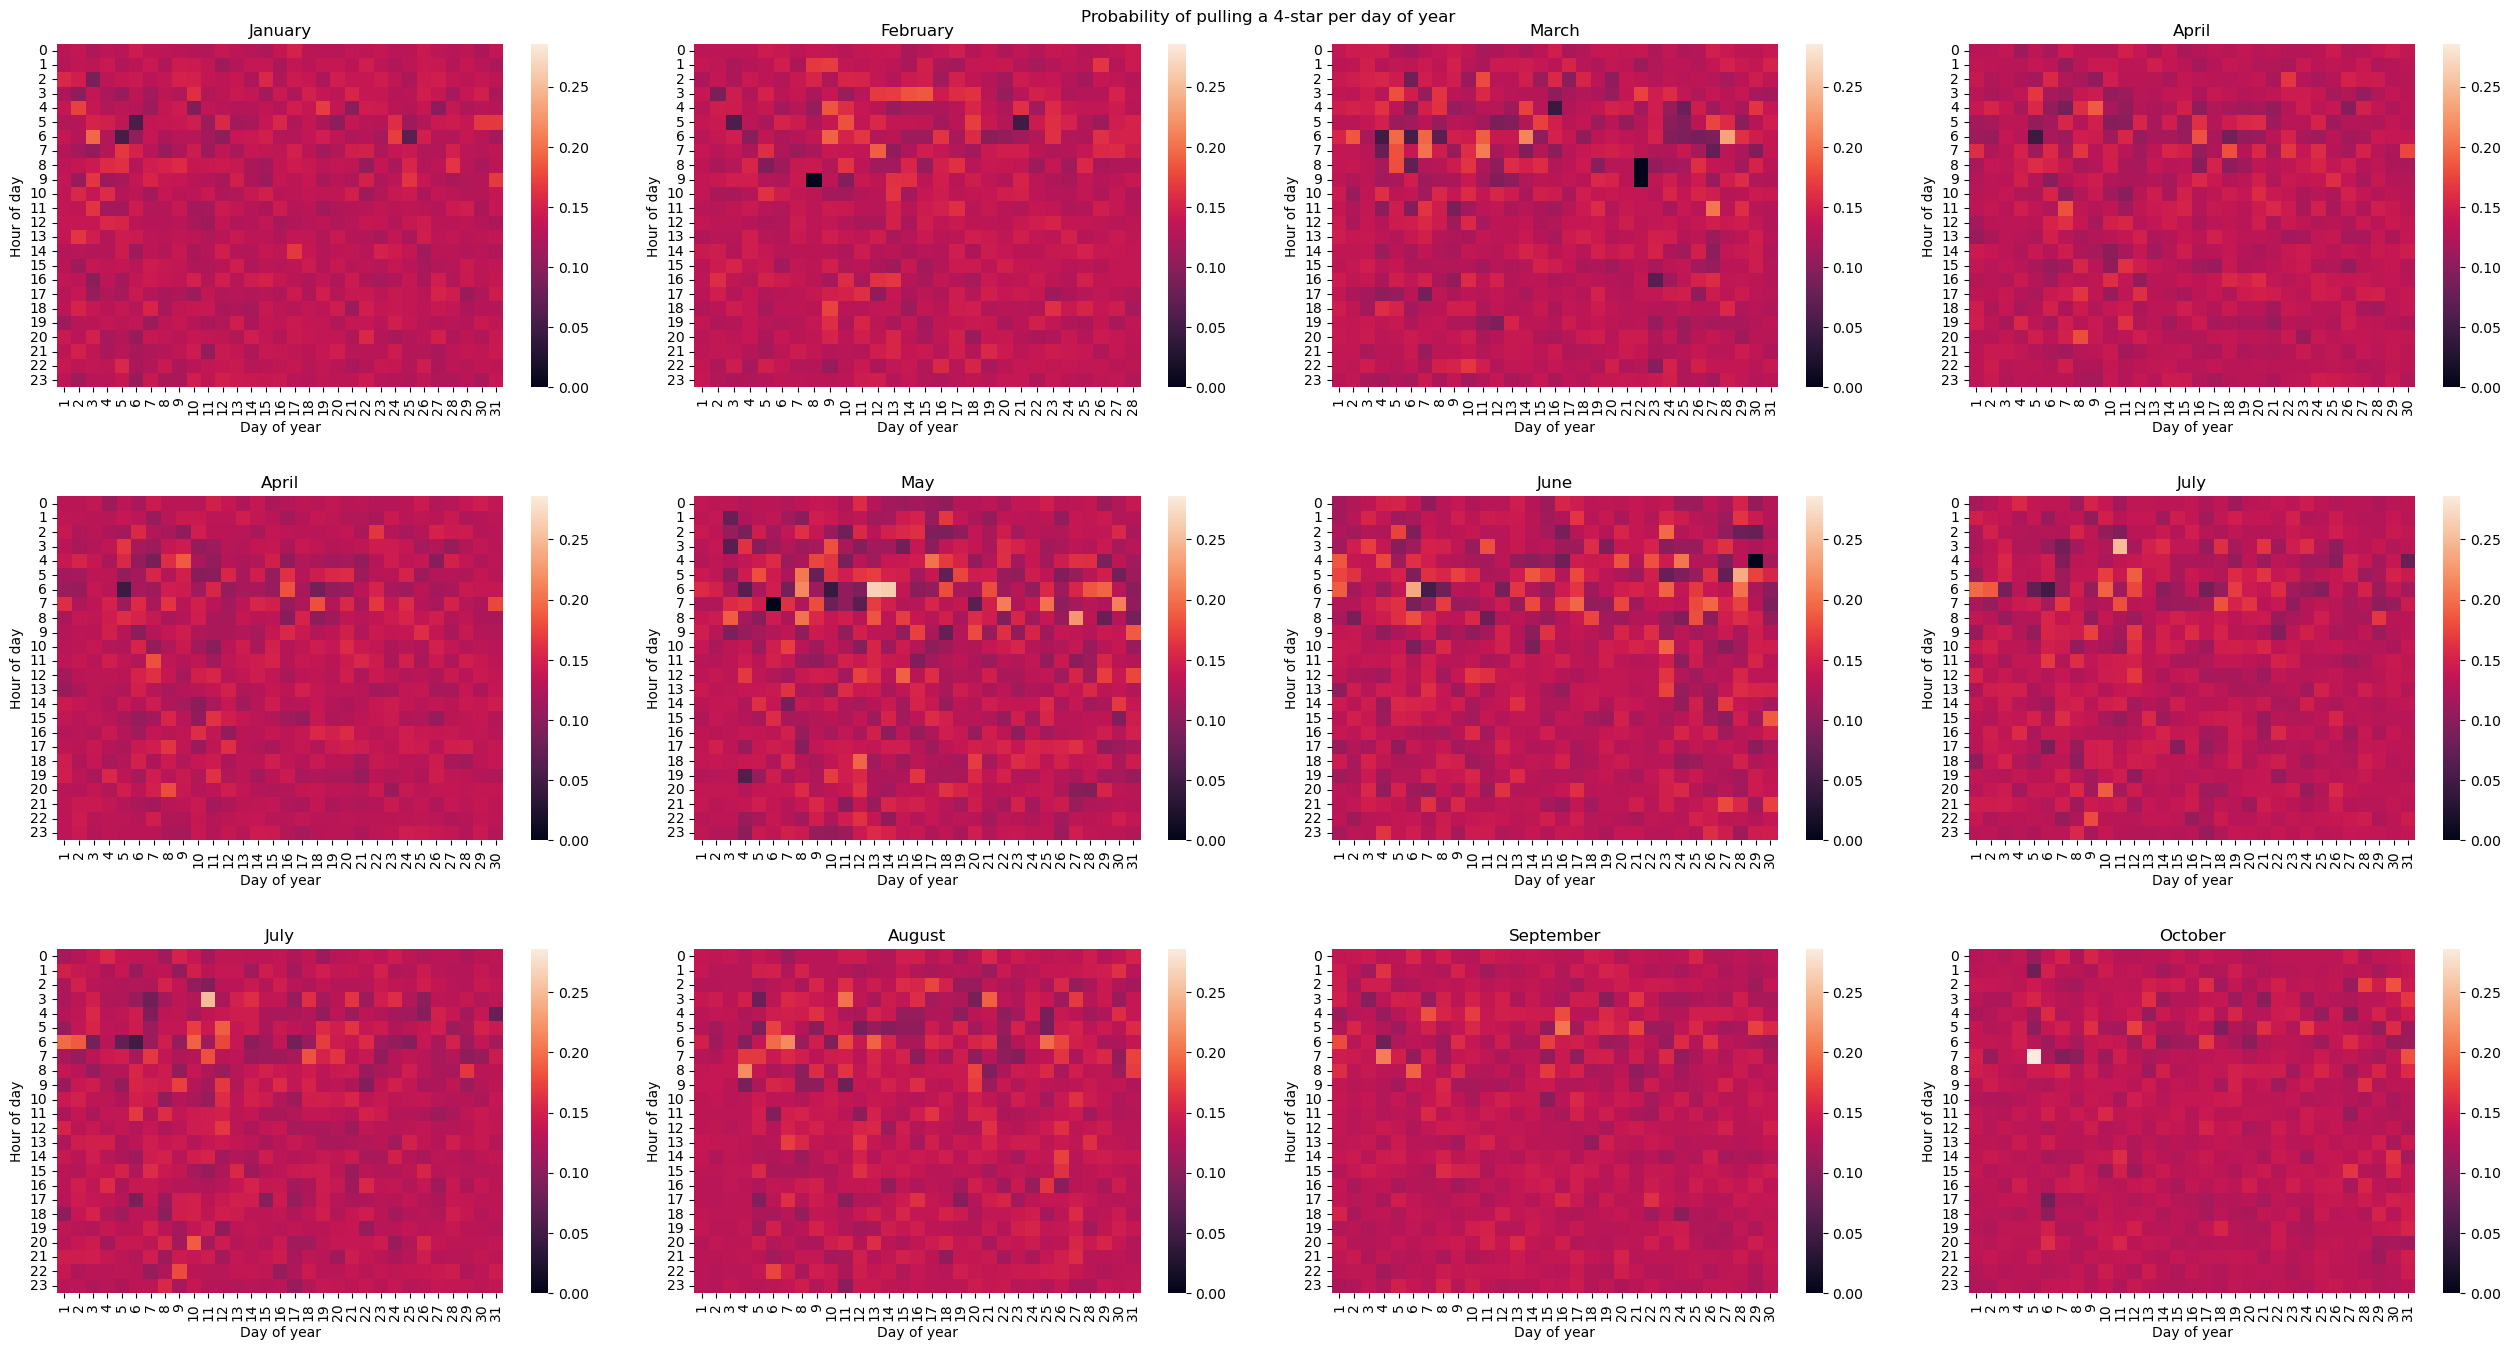

In [14]:
fig, axes = plt.subplots(3, 4, figsize=YEAR_FIGSIZE)
doy_heatmap(all_fours, axes)
fig.tight_layout(pad=3.)
fig.suptitle("Probability of pulling a 4-star per day of year")


## Days since release


In [15]:
total_dsr = transform_func(full_df, dsr_transformer, (24, DAYS_SINCE_RELEASE))
all_total, all_fives, all_fours = total_dsr


In [16]:
DSR_ROWS = 4
DSR_PAD = 5.
DSR_FIGSIZE = (24, 16)


### Pulls


Text(0.5, 0.98, 'Number of pulls per day since release')

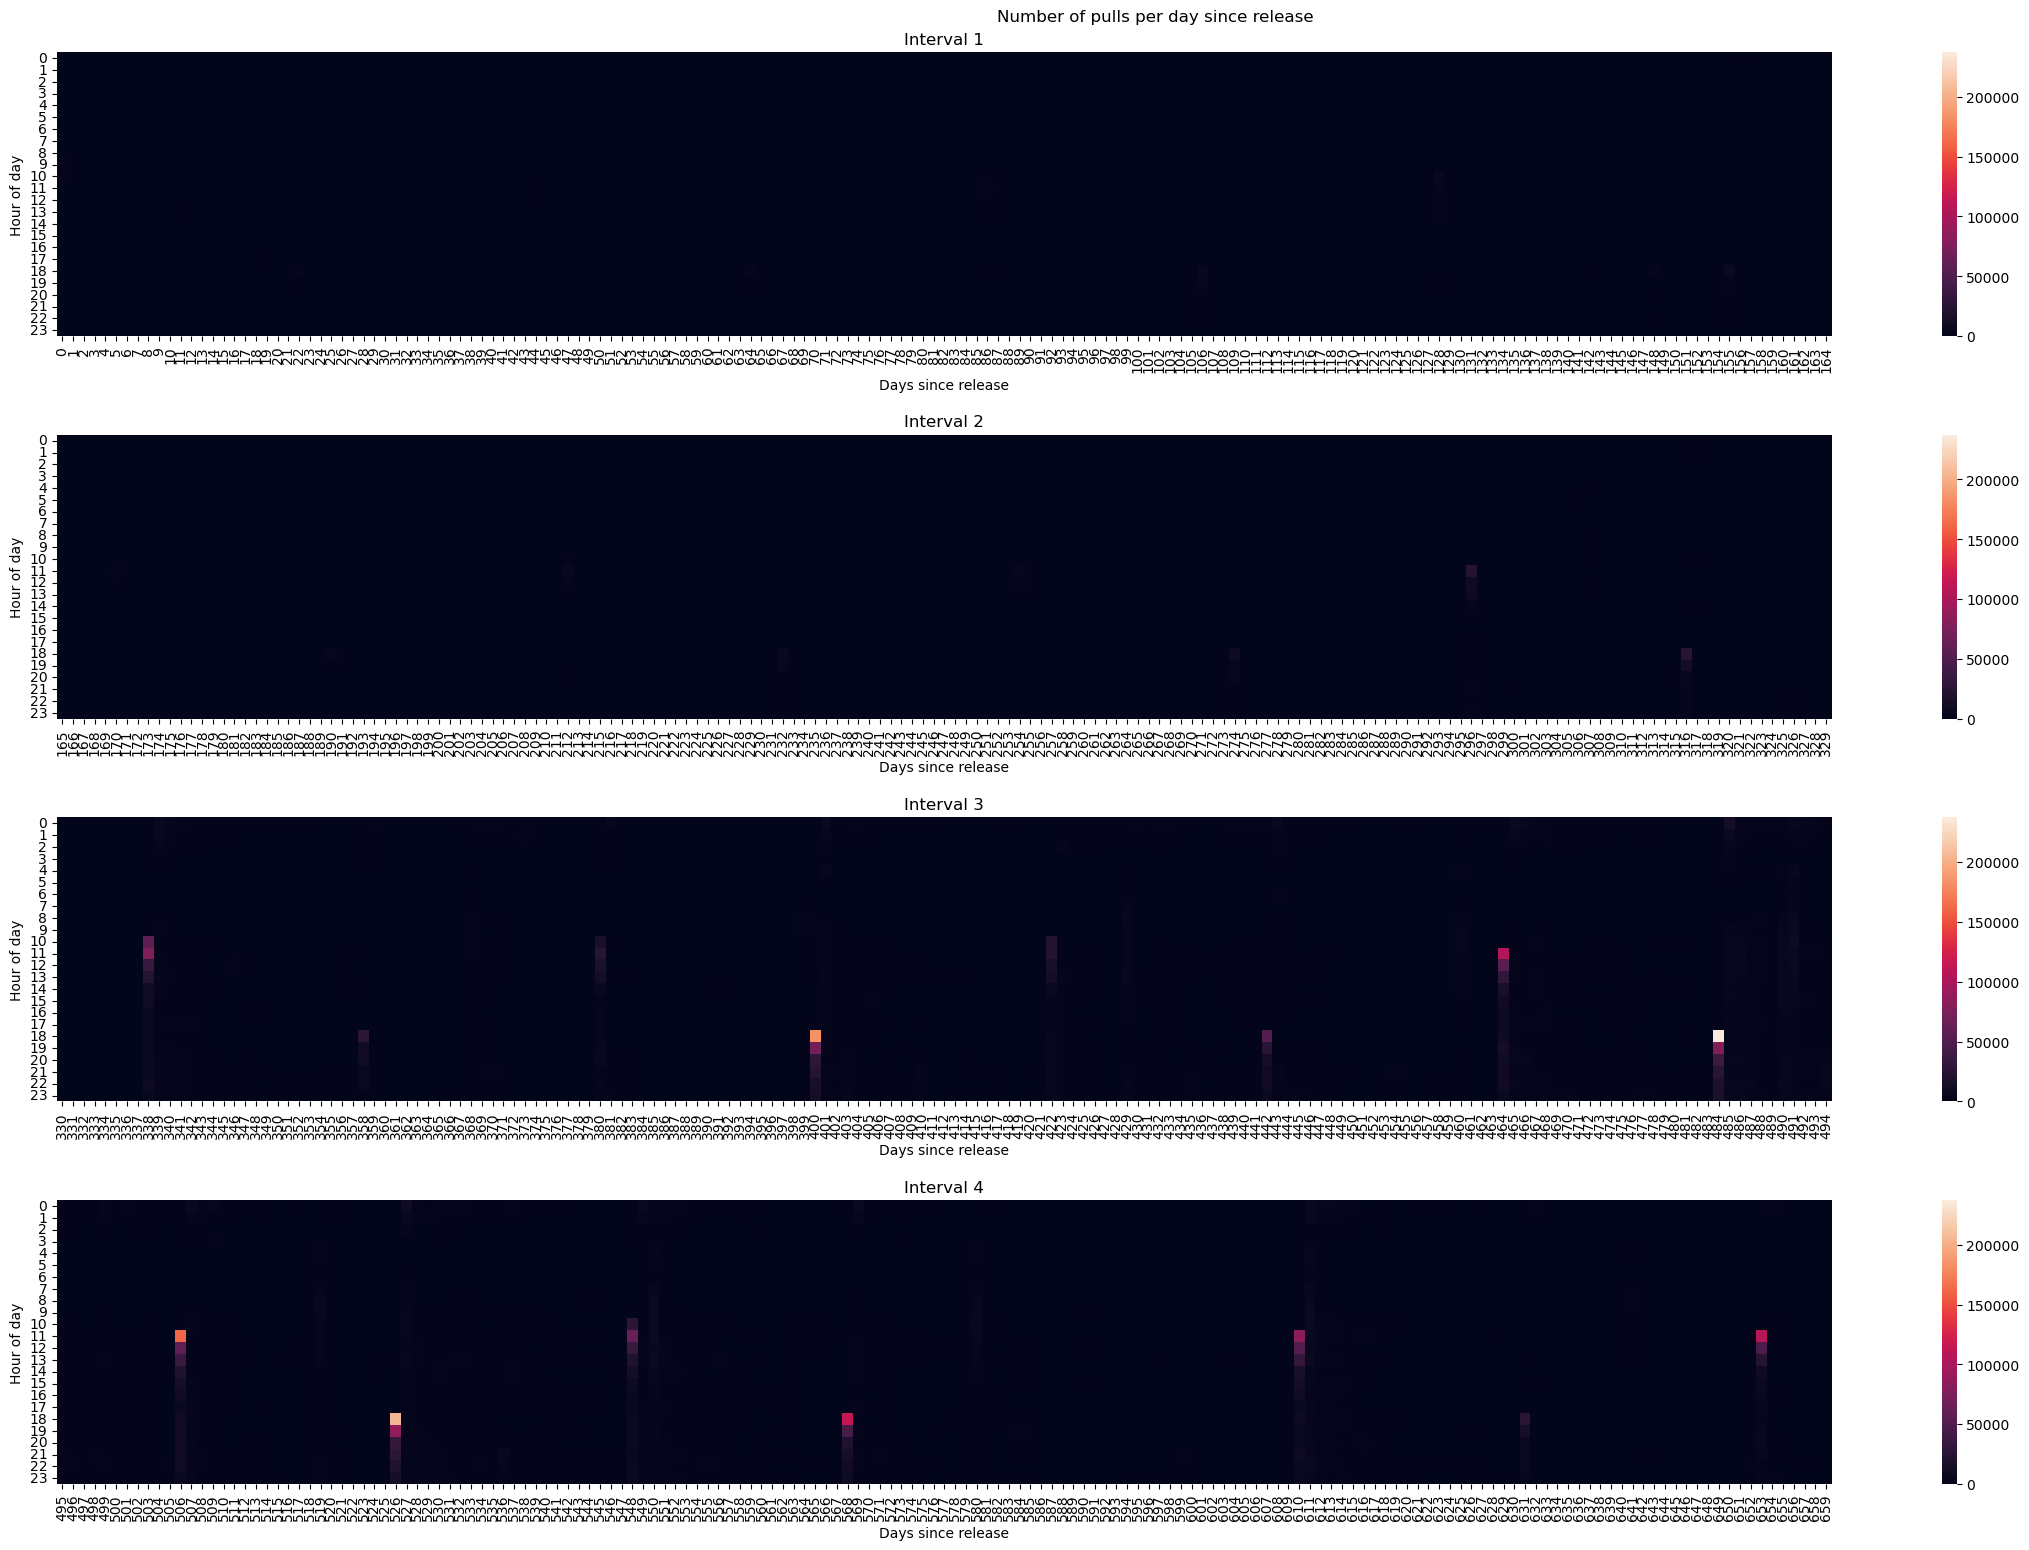

In [17]:
fig, axes = plt.subplots(DSR_ROWS, figsize=DSR_FIGSIZE)
fig.tight_layout(pad=DSR_PAD)
dsr_heatmap(all_total, axes, interval_name="Interval")
fig.suptitle("Number of pulls per day since release")


### 5-star


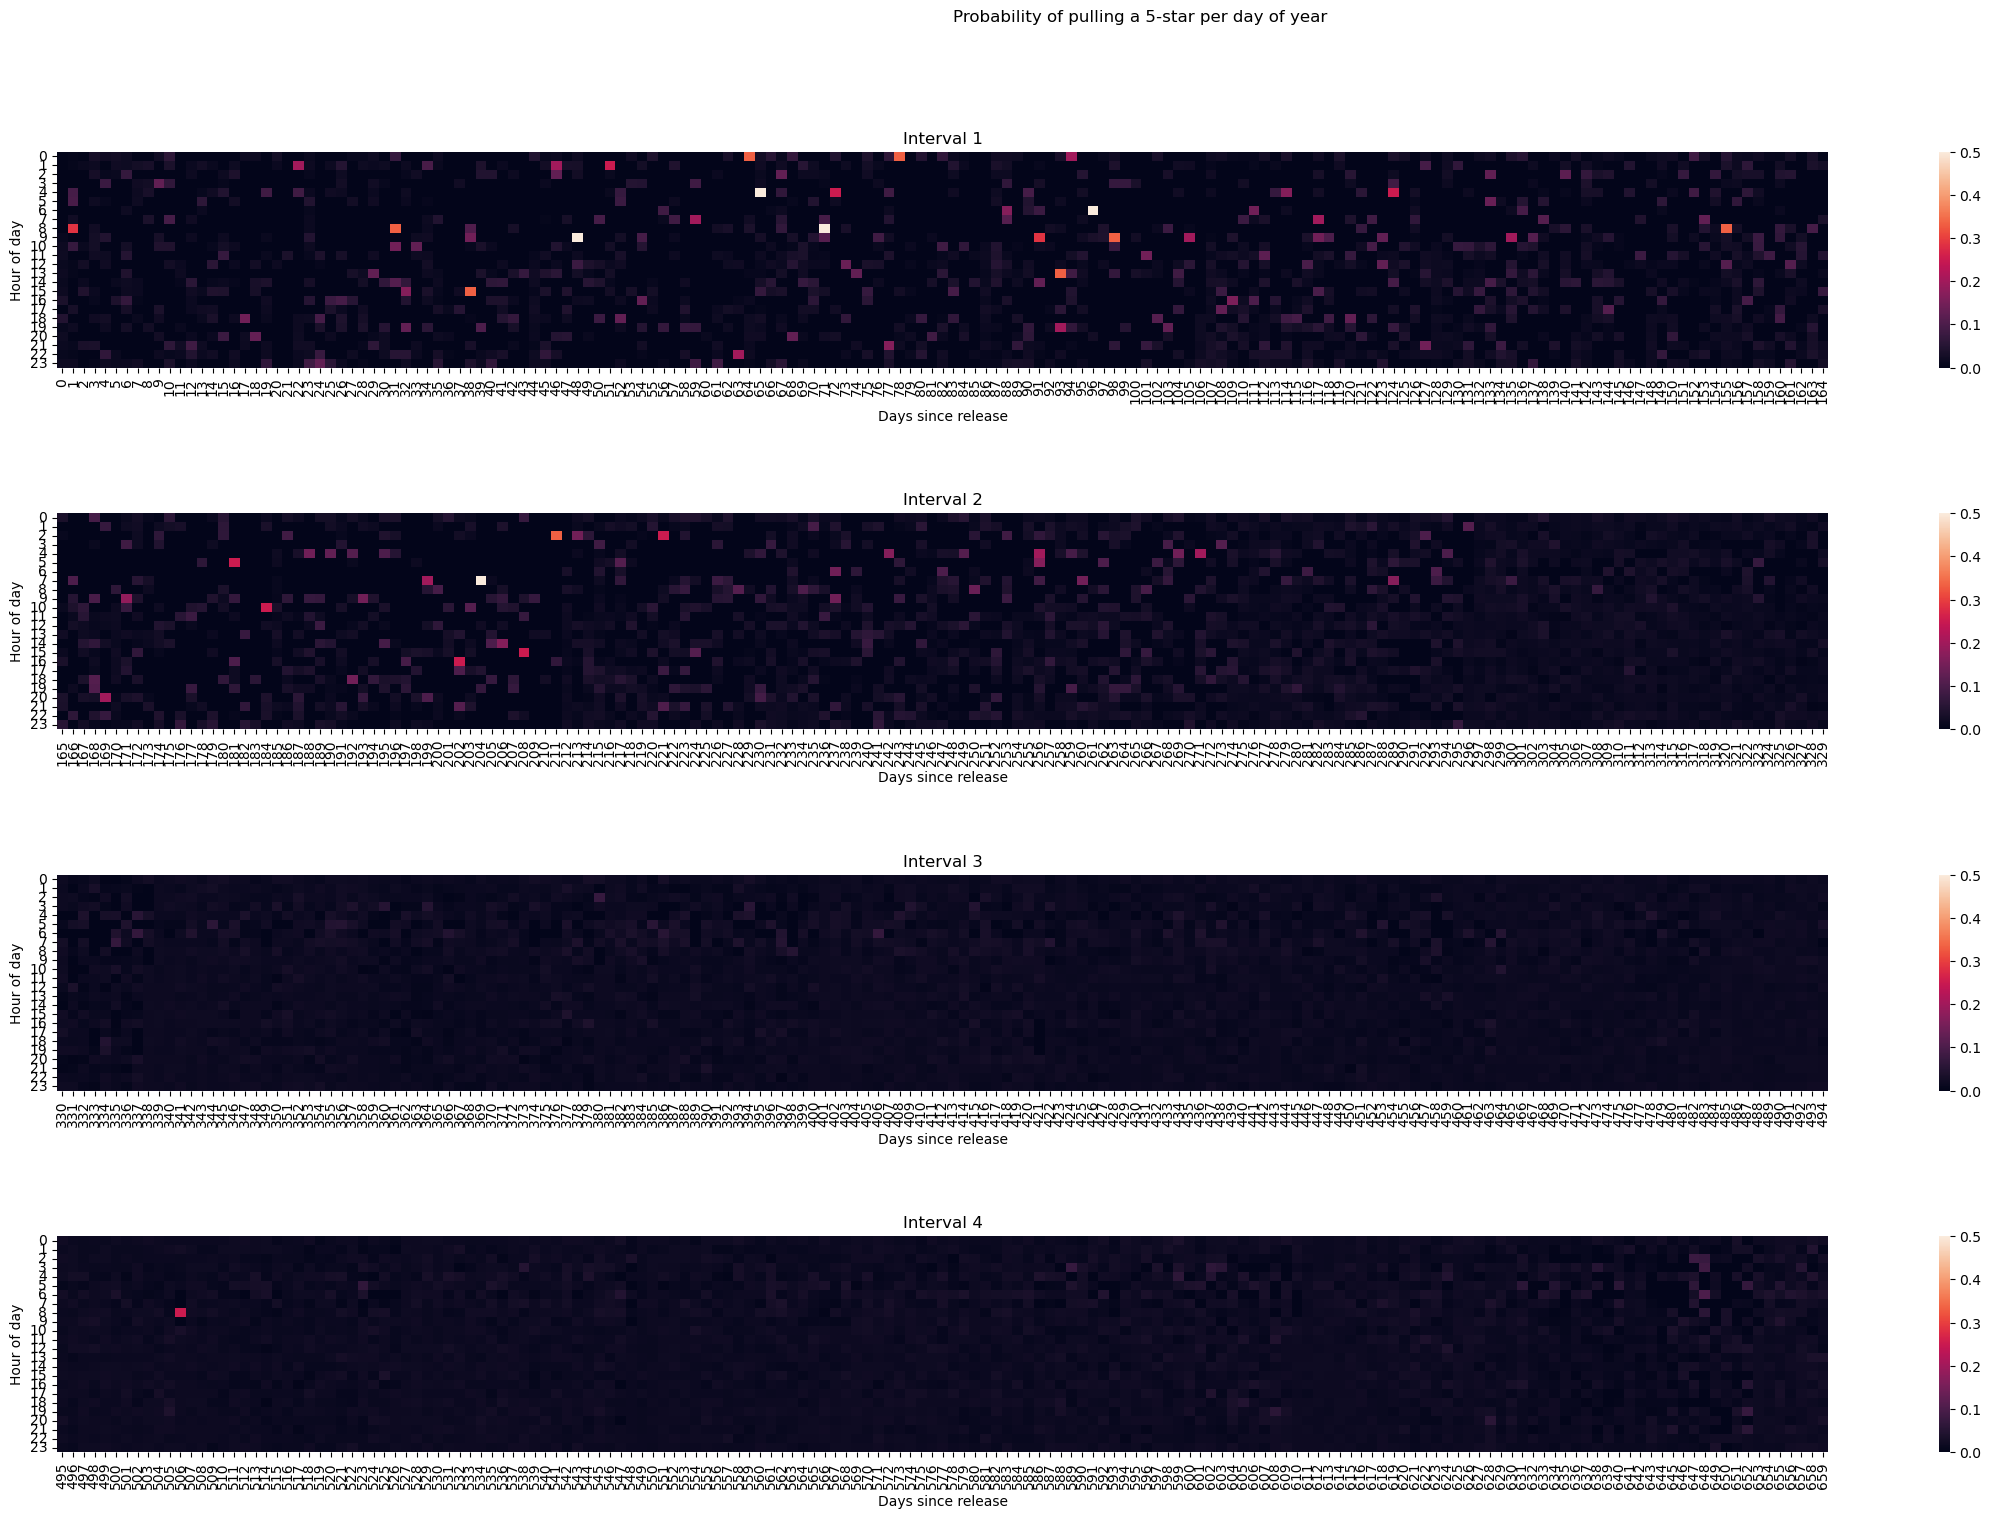

In [18]:
fig, axes = plt.subplots(DSR_ROWS, figsize=DSR_FIGSIZE)
dsr_heatmap(all_fives, axes, interval_name="Interval")
fig.suptitle("Probability of pulling a 5-star per day of year")
fig.tight_layout(pad=DSR_PAD)


### 4-star


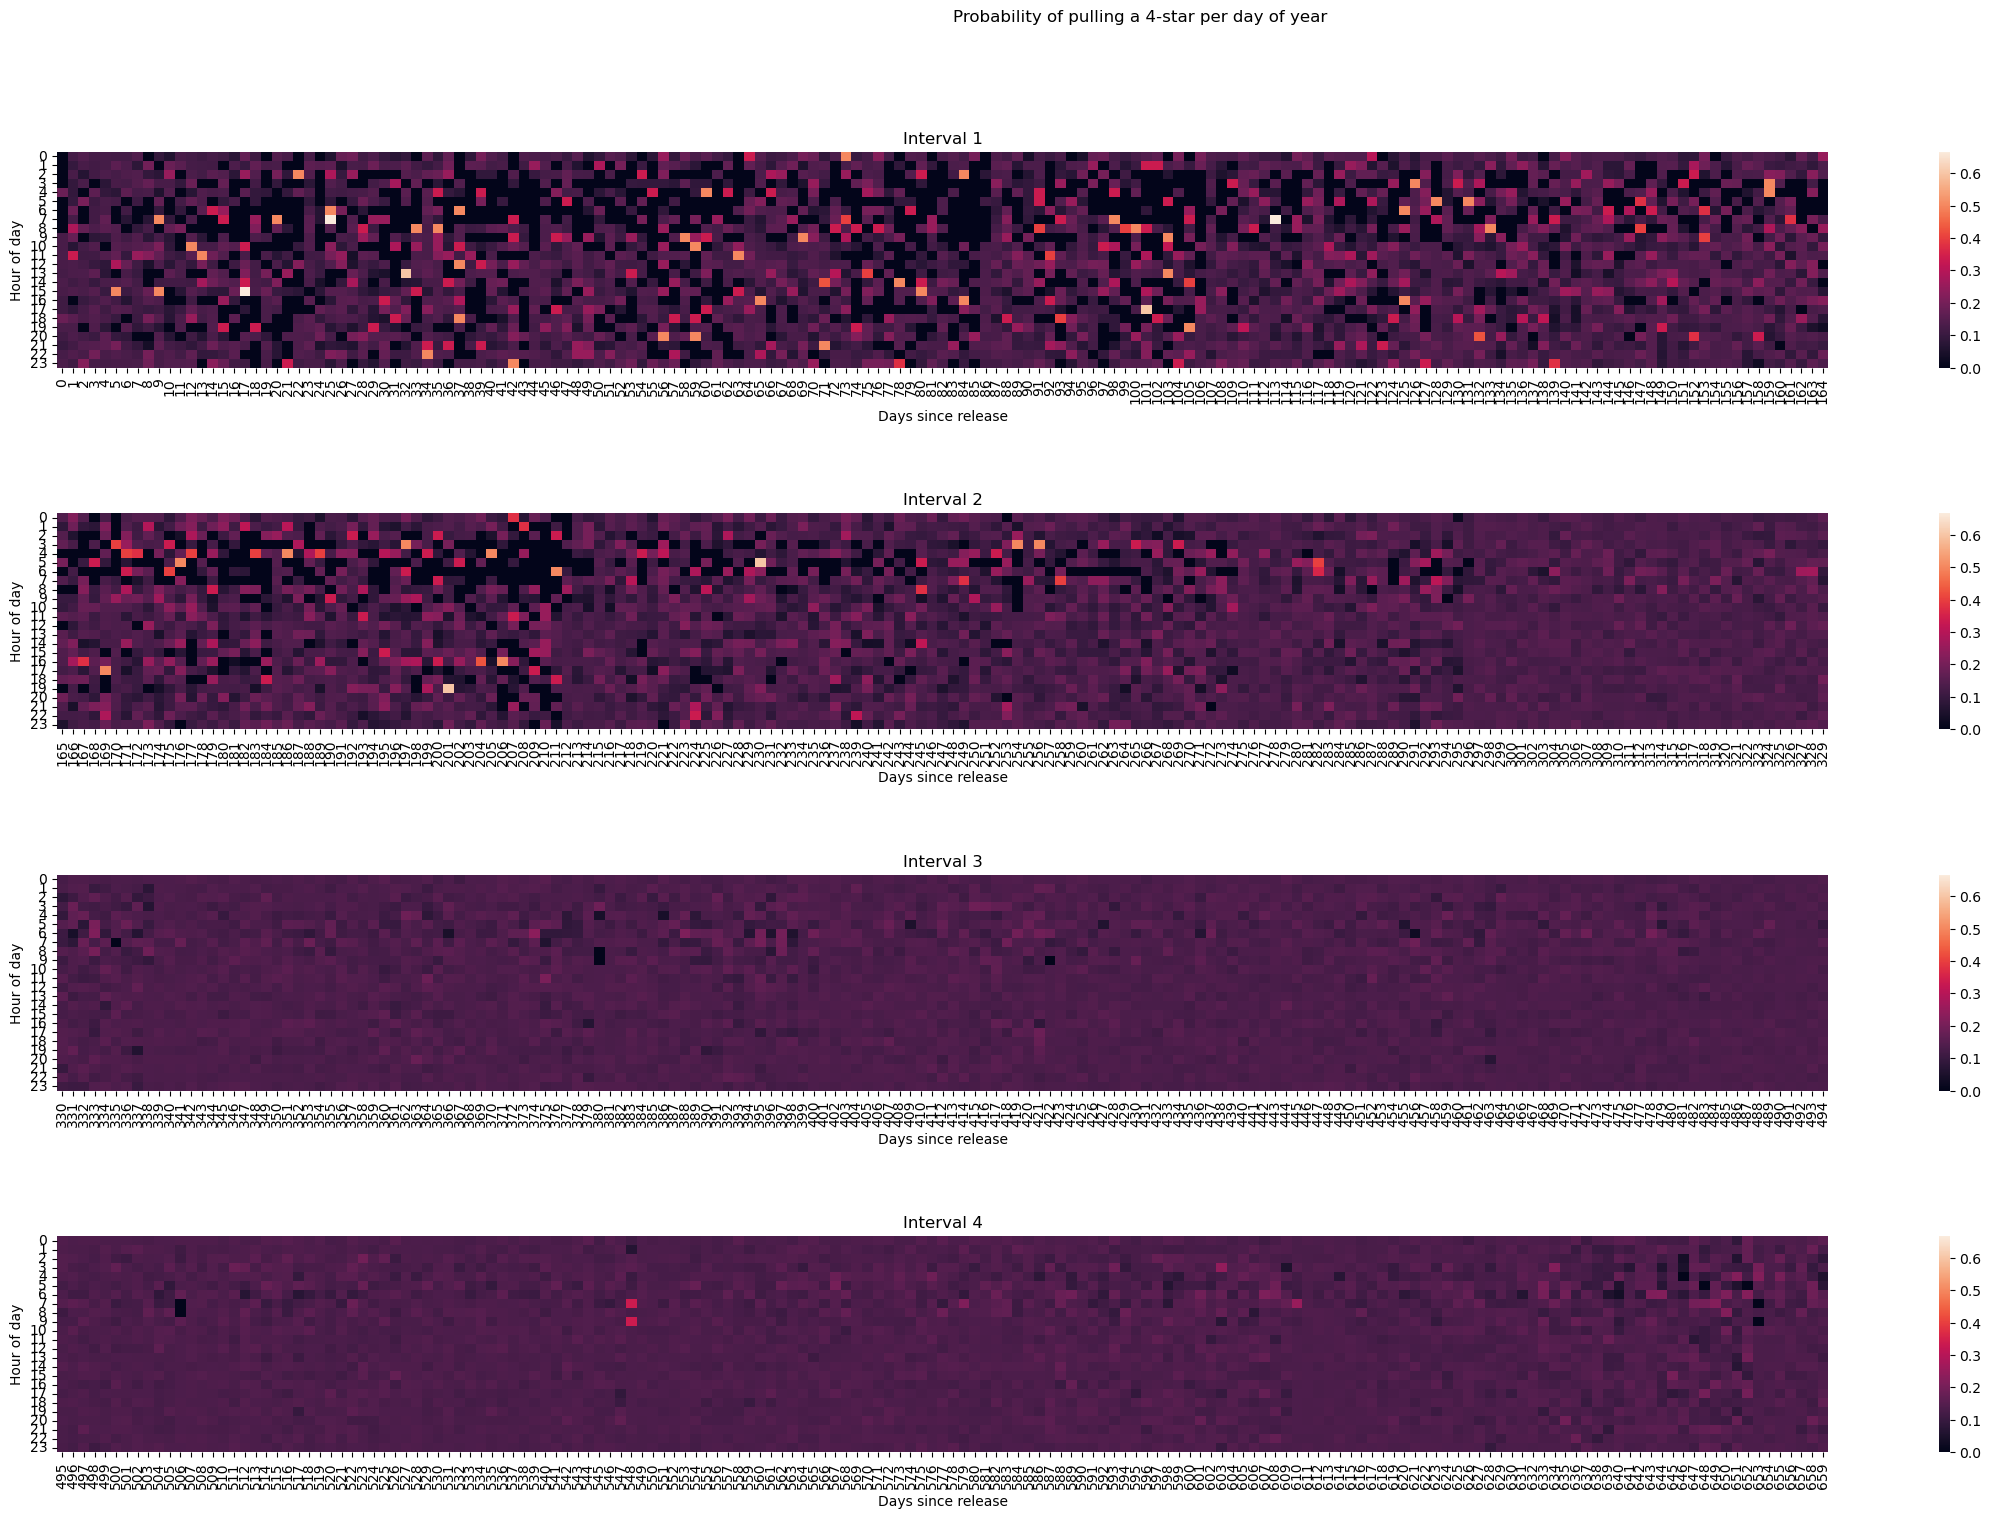

In [19]:
fig, axes = plt.subplots(DSR_ROWS, figsize=DSR_FIGSIZE)
dsr_heatmap(all_fours, axes, interval_name="Interval")
fig.suptitle("Probability of pulling a 4-star per day of year")
fig.tight_layout(pad=DSR_PAD)


## Observations

### Number of Pulls

Other than some outliers, assumed to be the days where new banners come out, the number of pulls at different hours
of each day seem to be pretty uniform.

### Getting 5/4-star

Somehow, at least for the first year or so after the game's launch, there seems to be a pattern where
if a player pulls gacha some time between 2-10am, they are more likely to pull either a 4 or 5 star item.


In [20]:
print(
    f"Mean of Prob(4- or 5-star) 2-10am: \t{np.mean(all_fives[:11, :]) * 100}%")
print(
    f"Mean of Prob(4- or 5-star) not 2-10am: \t{np.mean(all_fives[11:, :]) * 100}%")
print(f"Mean of Prob(4- or 5-star) all day: \t{np.mean(all_fives) * 100}%")


Mean of Prob(4- or 5-star) 2-10am: 	1.5044655788660257%
Mean of Prob(4- or 5-star) not 2-10am: 	1.4954743286995618%
Mean of Prob(4- or 5-star) all day: 	1.4995953183591908%


Although not very significant, we can see that there is a _very small_ difference when it comes to
the mean of probability of getting a 5-star.


# Second Try: _Different banners and outliers are ignored_

One of the patterns seen is that the probability seems to become more and more uniform as time goes on.
Thus, we are going to ignore the _"combined"_ grouping, meaning that we will ignore the day-of-X groupings
in the following attempt(s).

Additionally, since Genshin Impact comes out with new banners every now and then which would impact the
maximum and minimum value of the number of pulls per day, making the mean and visualization confusing.
Thus, we are going to ignore the ignore the outliers. During the presentation, any value above the 95-percentile
are ignored. However, I believe that using standard deviation might be better to identify outliers, making
this part already different from the presentation.

Note that we will only look at 5-star drops over time since release only just to save a bit of space and time.


In [21]:
NEW_DSR_FIGSIZE = (25, 14)
DSR_ROWS = 3


In [22]:
def transform_ignore_outliers(full_banner: np.ndarray, percentile=99):
    q_val = np.percentile(full_banner, percentile)
    m_val = np.mean(full_banner)

    outliers = full_banner > q_val
    copy = full_banner.copy()
    copy[outliers] = m_val

    return copy


## Permanent Banner


In [23]:
full_perm = full_df[full_df.Banner == 200]
perm_transform = transform_func(
    full_perm, dsr_transformer, (24, DAYS_SINCE_RELEASE))
perm_all, perm_5stars, _ = perm_transform
perm_all = transform_ignore_outliers(perm_all)


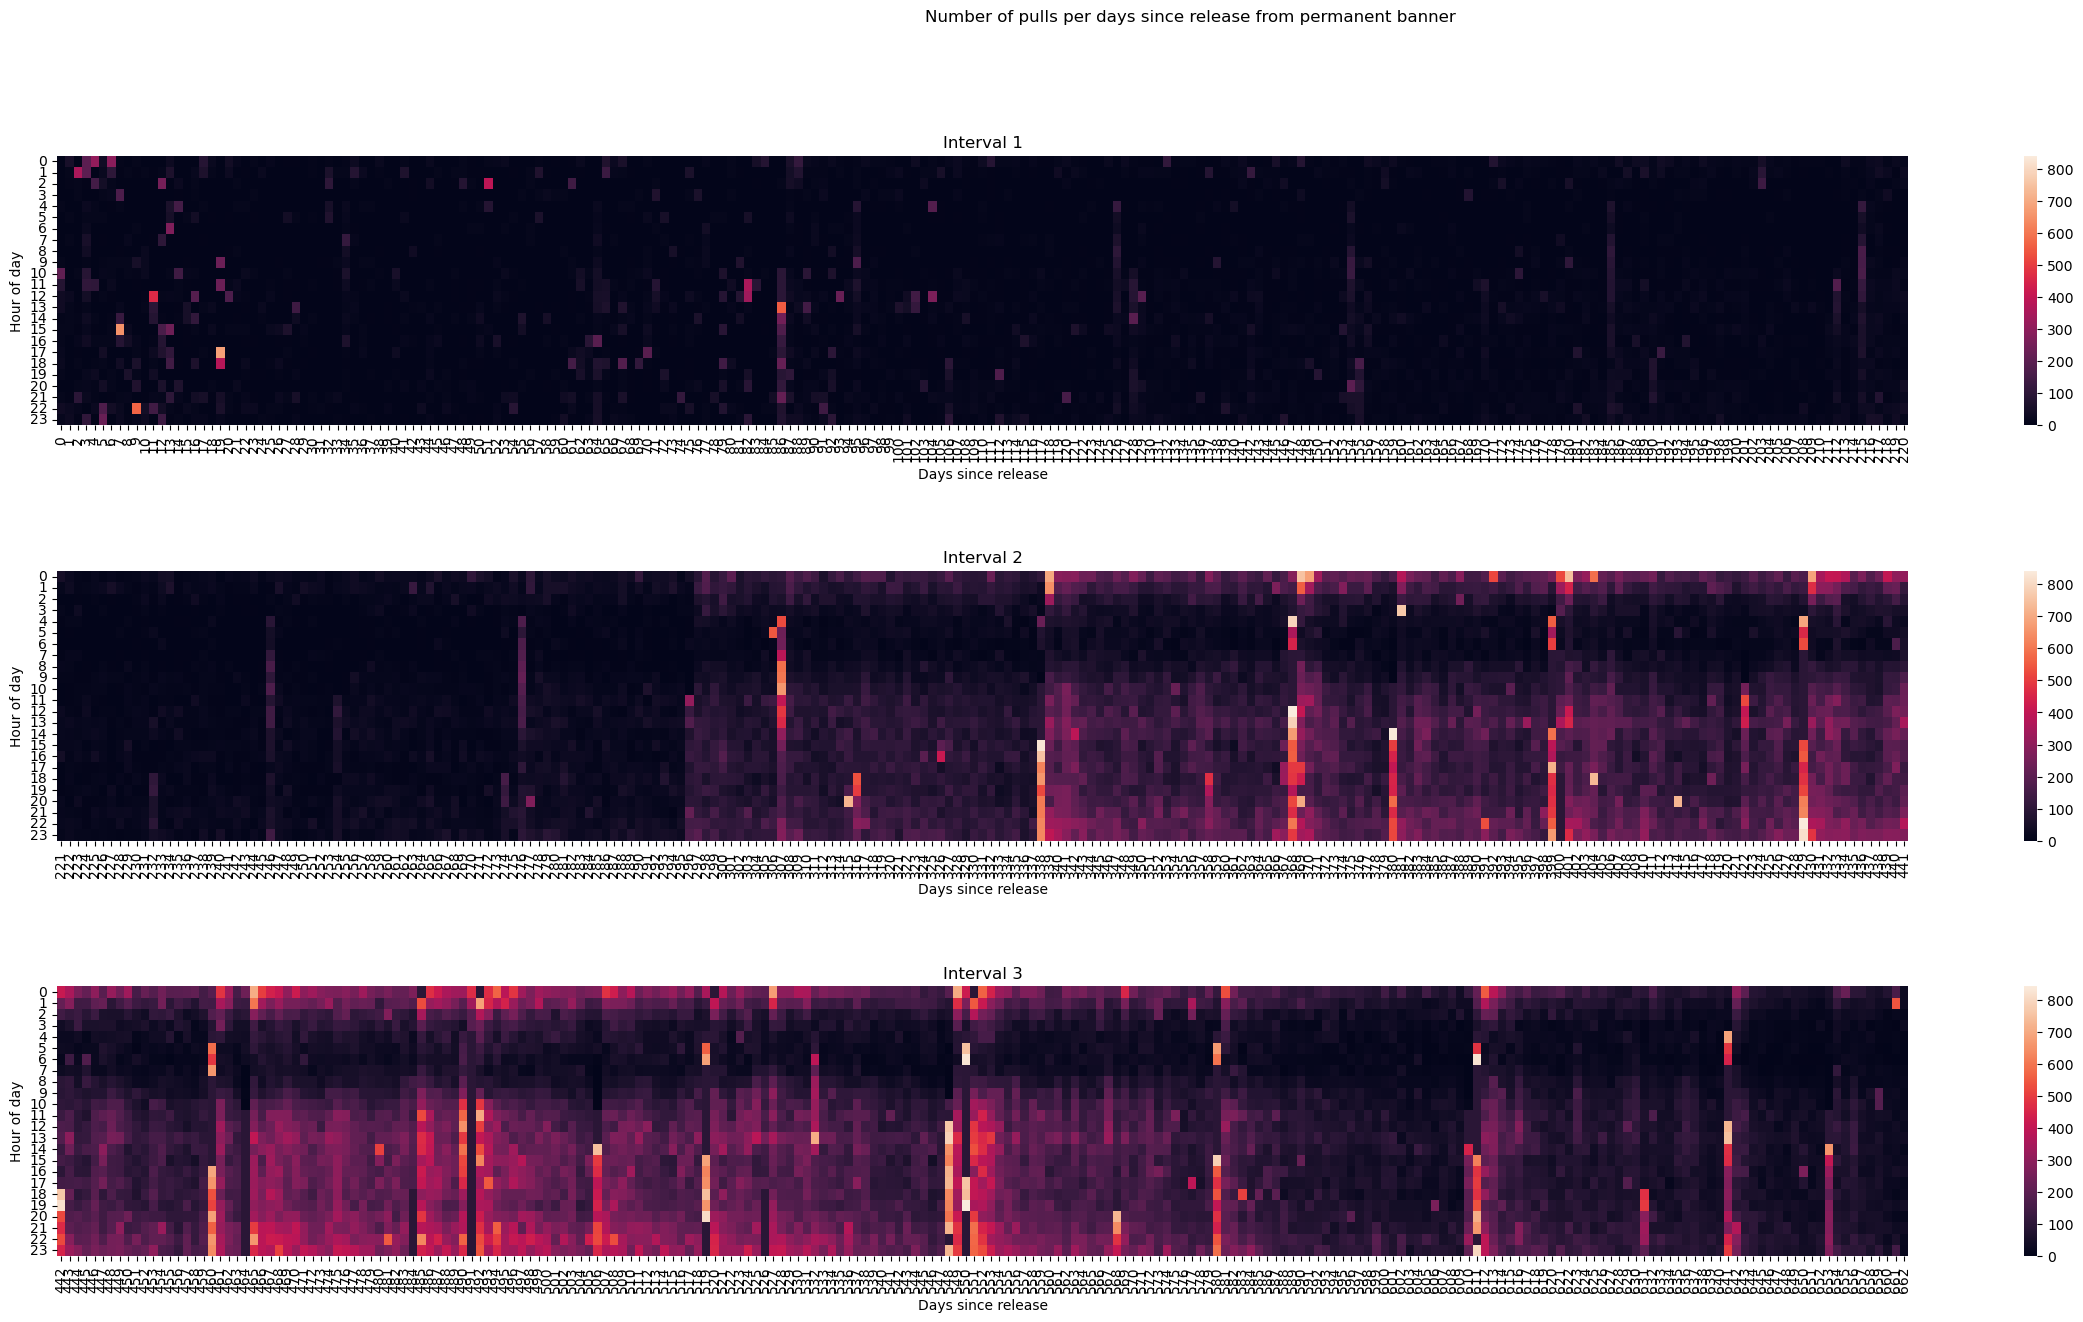

In [24]:
fig, axes = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(perm_all, axes)
fig.suptitle("Number of pulls per days since release from permanent banner")
fig.tight_layout(pad=DSR_PAD)


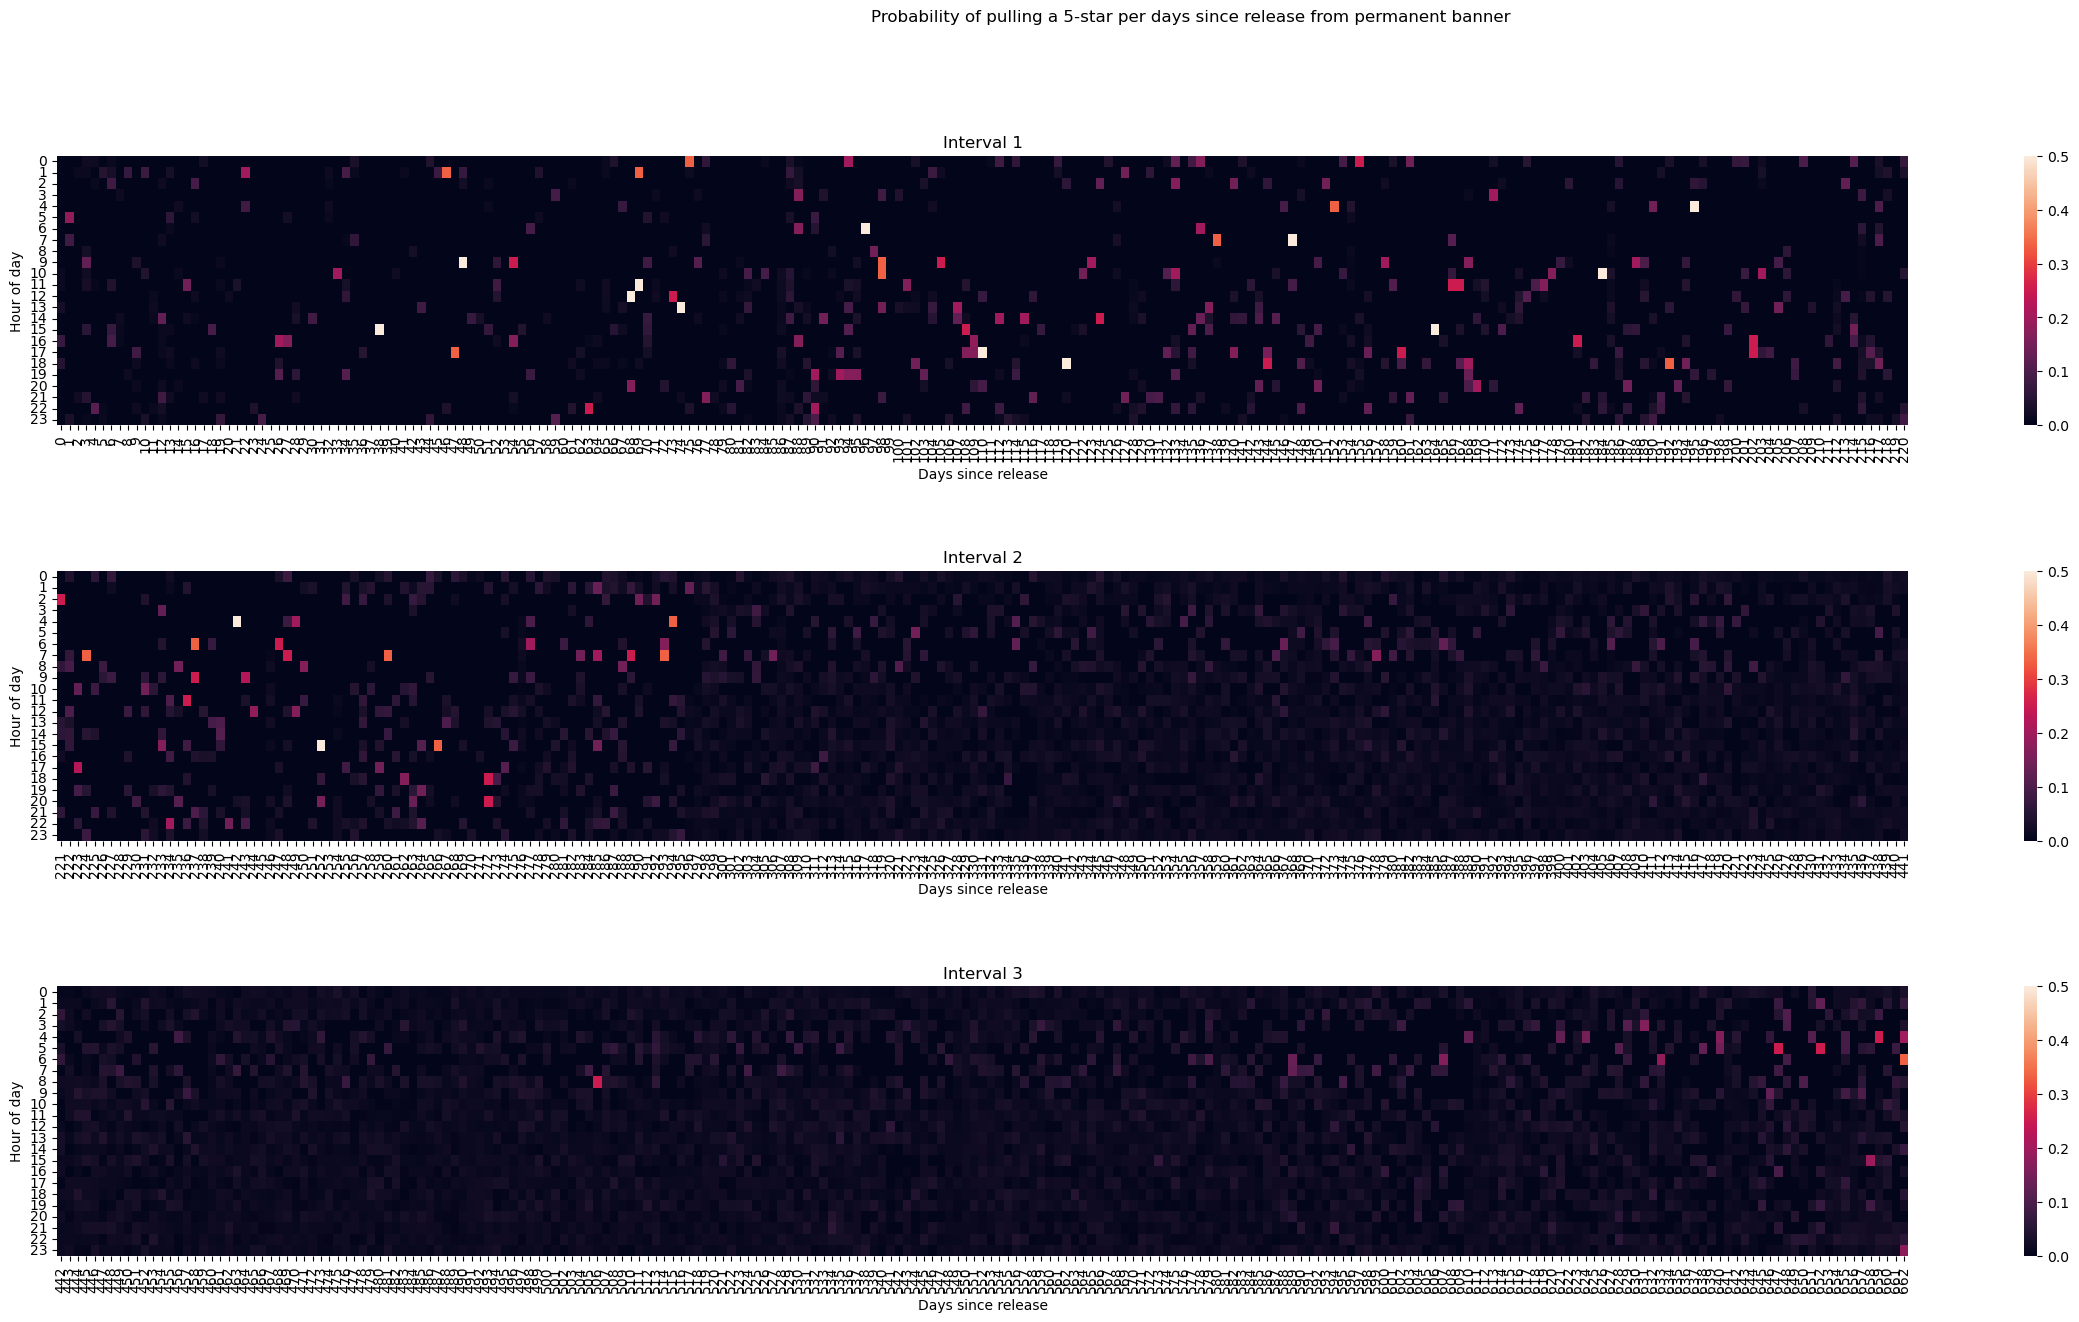

In [25]:
fig, axes = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(perm_5stars, axes, interval_name="Interval")
fig.suptitle(
    "Probability of pulling a 5-star per days since release from permanent banner")
fig.tight_layout(pad=DSR_PAD)


## Limited Character Banner


In [26]:
full_char = pd.concat([full_df[full_df.Banner == 301],
                      full_df[full_df.Banner == 400]])
char_all, char_5stars, _ = transform_func(
    full_char, dsr_transformer, (24, DAYS_SINCE_RELEASE))
char_all = transform_ignore_outliers(char_all)


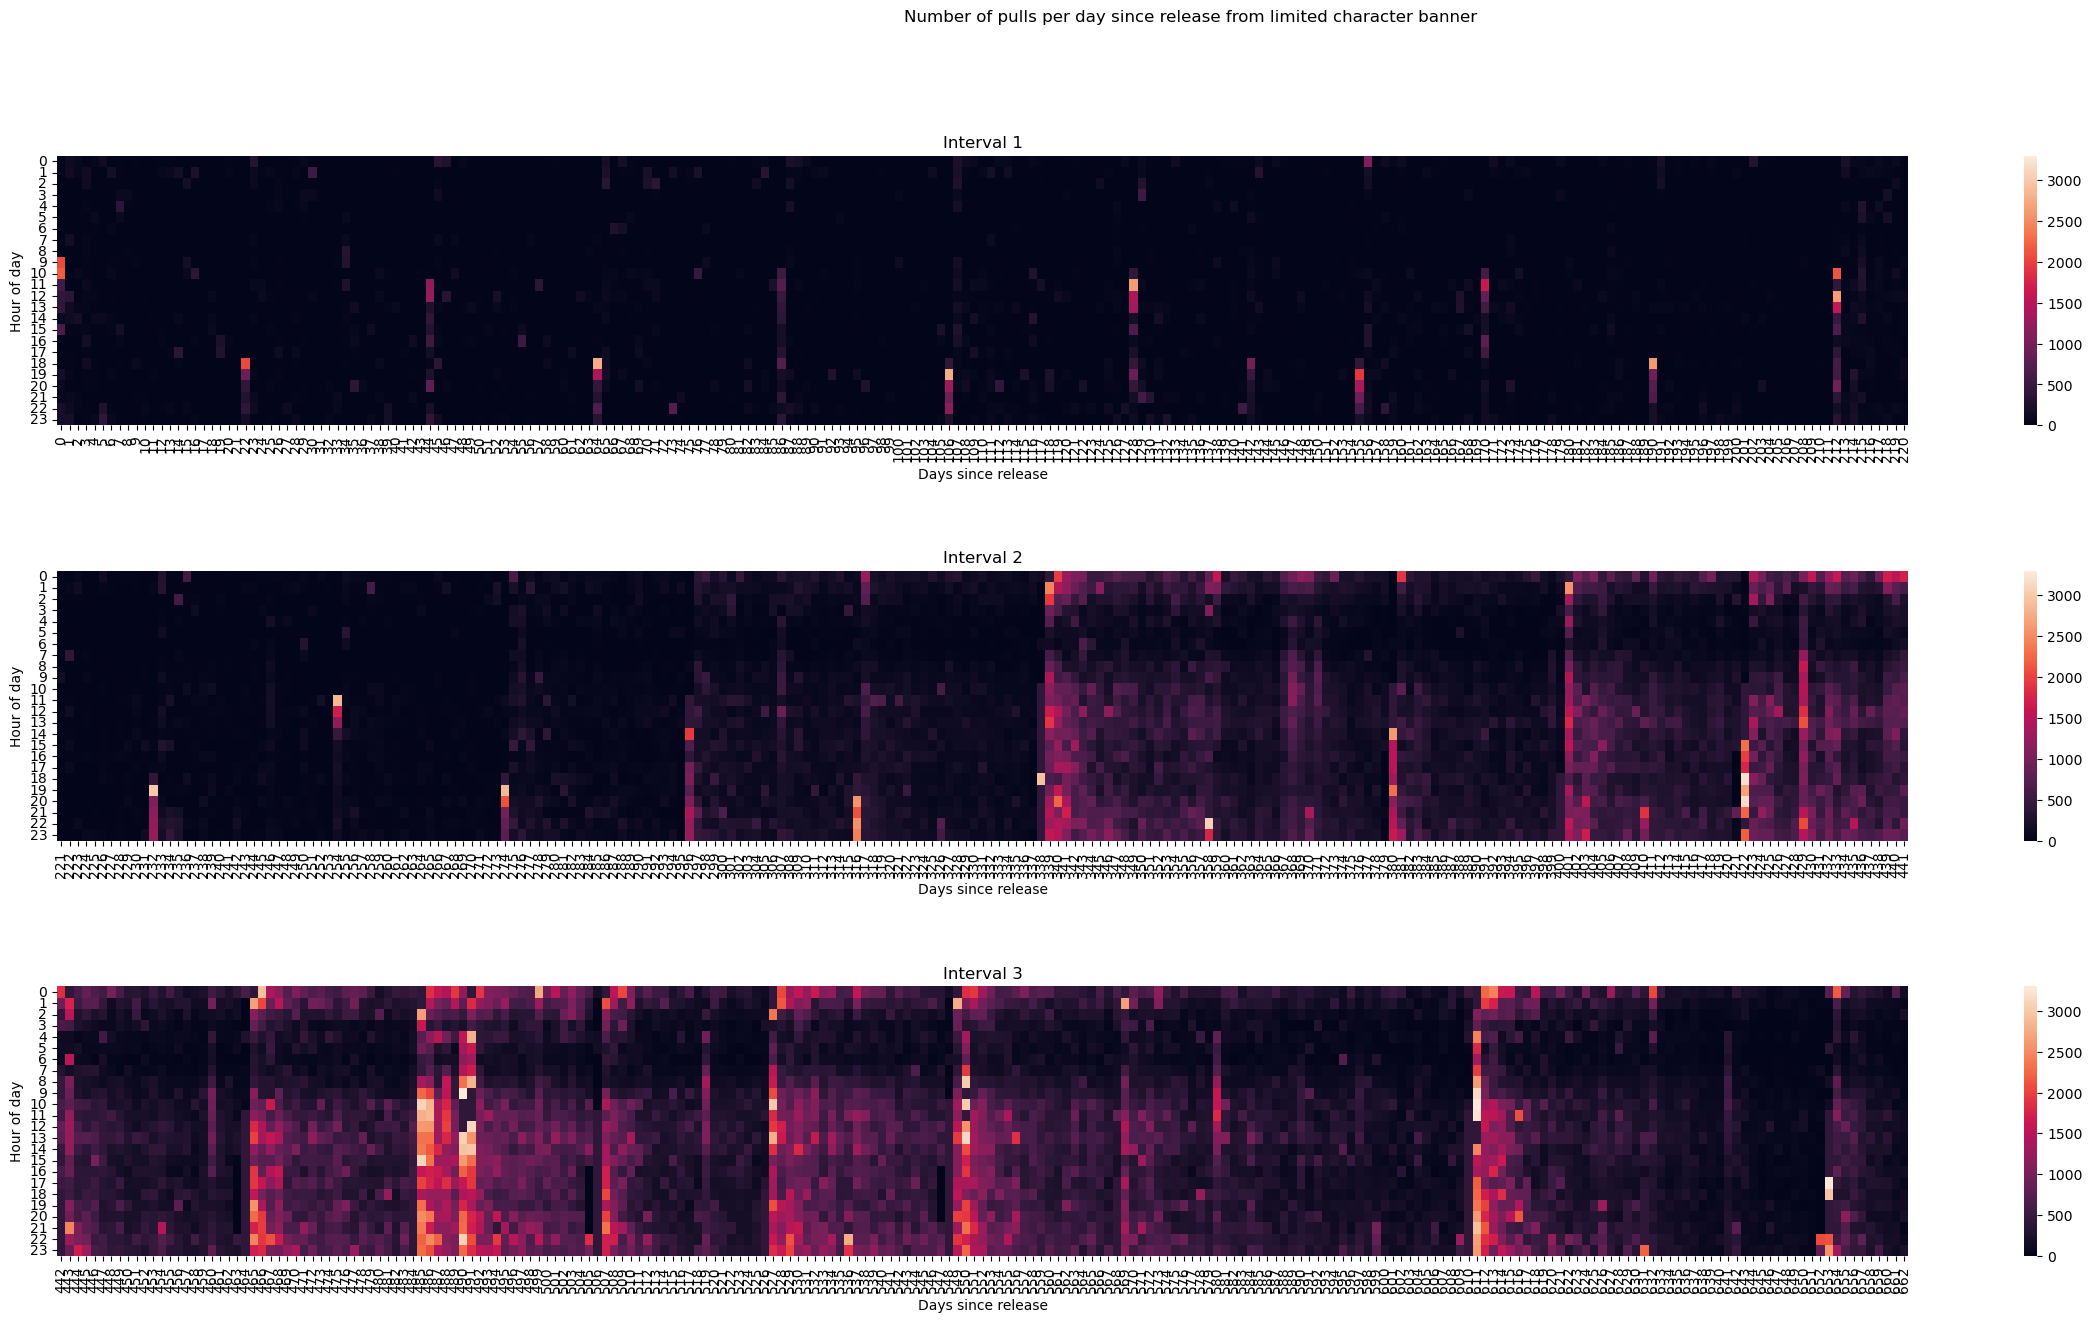

In [27]:
fig, axes = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(char_all, axes, interval_name="Interval")
fig.suptitle(
    "Number of pulls per day since release from limited character banner")
fig.tight_layout(pad=DSR_PAD)


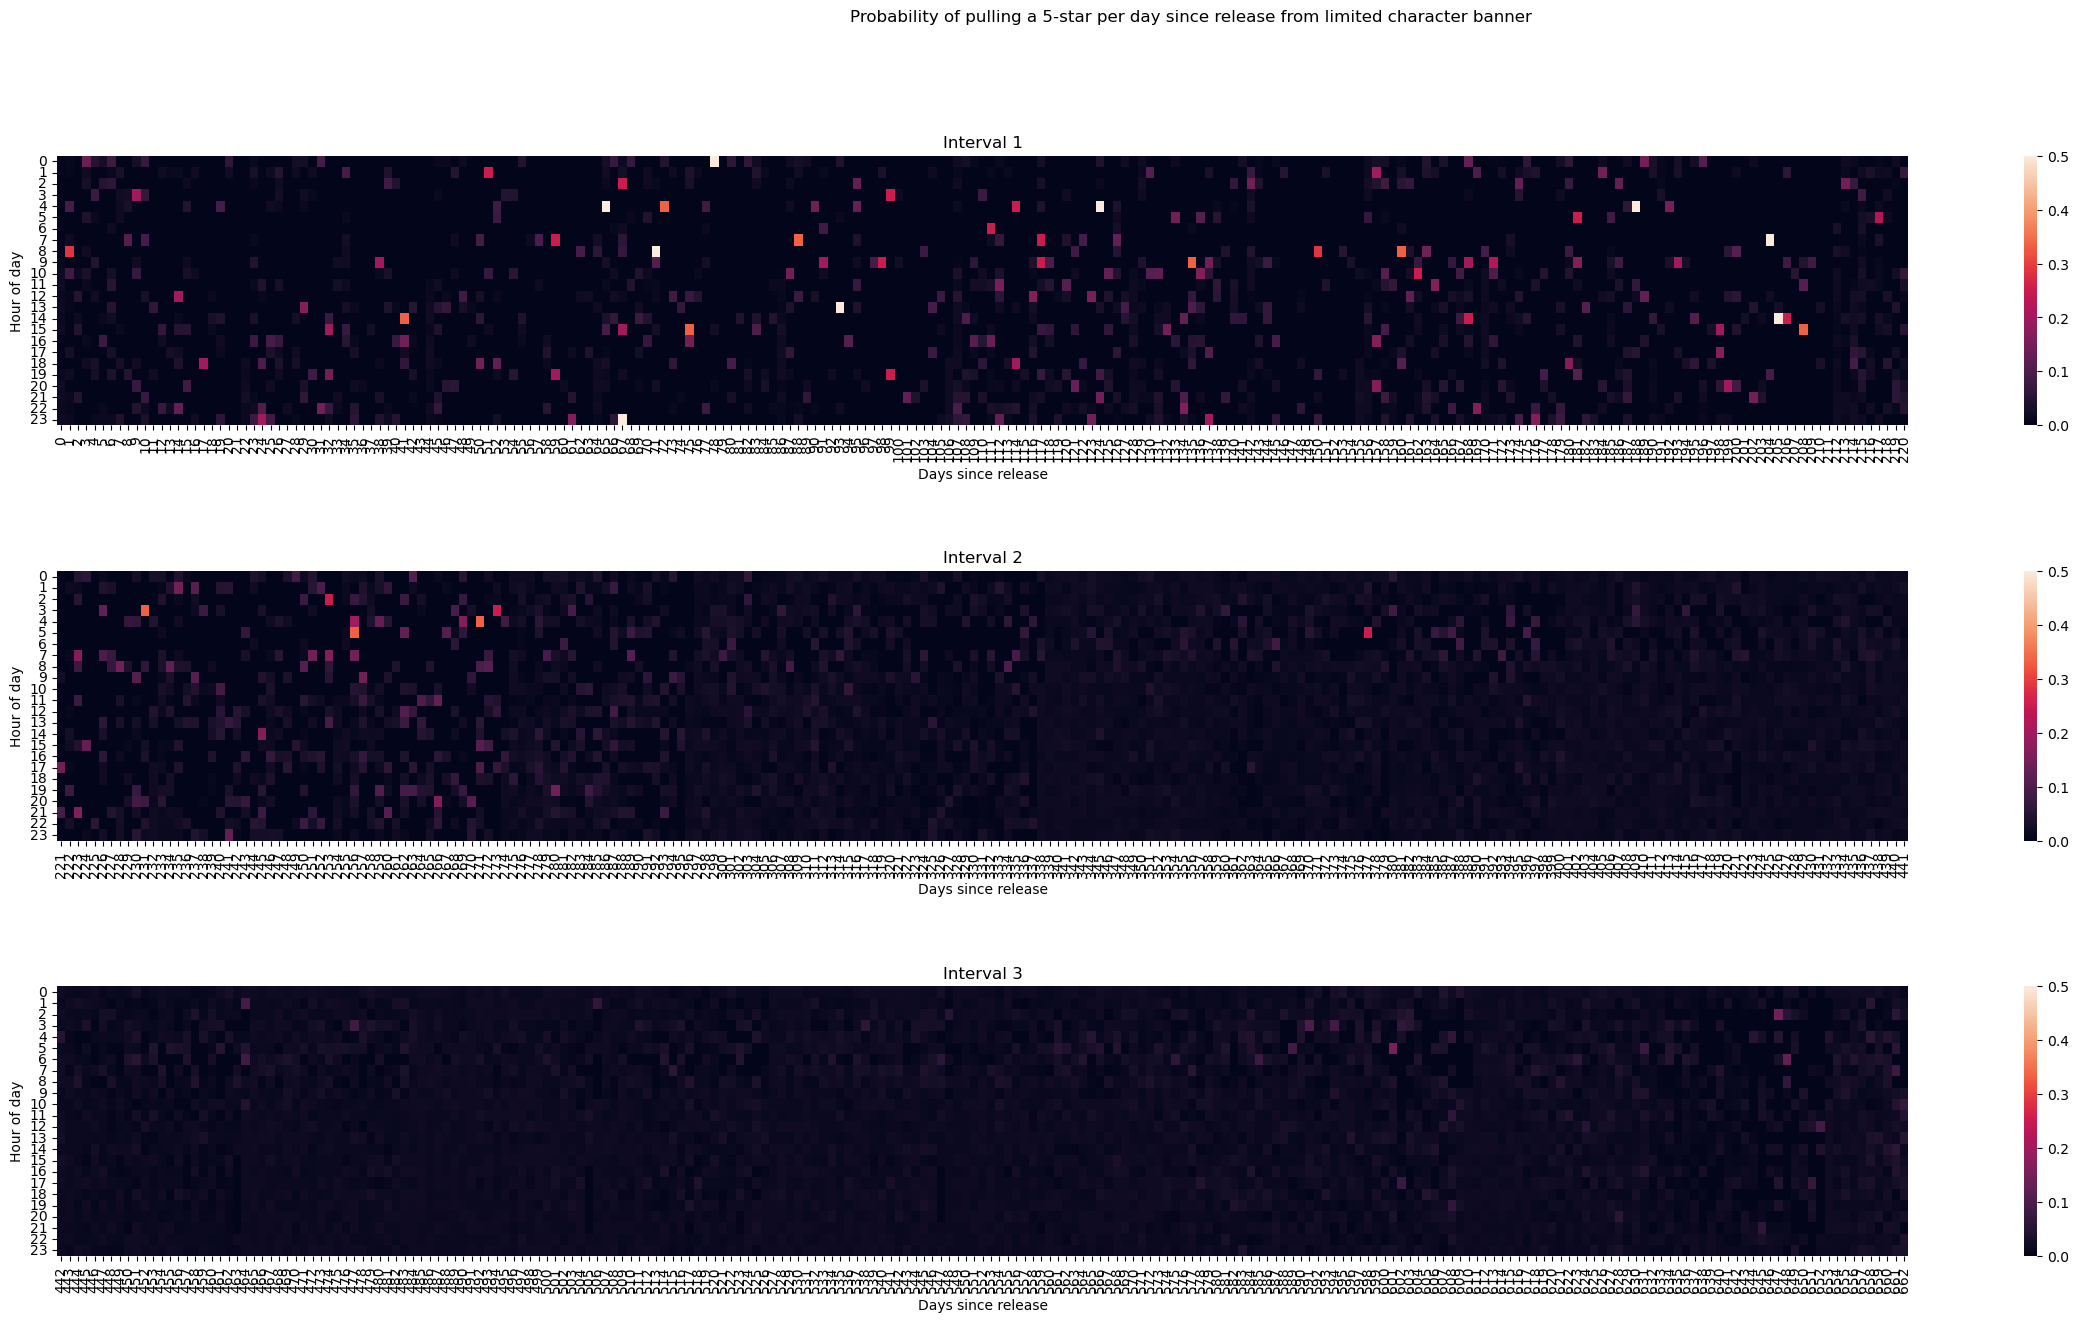

In [28]:
fig, axes = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(char_5stars, axes, interval_name="Interval")
fig.suptitle(
    "Probability of pulling a 5-star per day since release from limited character banner")
fig.tight_layout(pad=DSR_PAD)


## Limited Weapon Banner


In [29]:
full_weapon = full_df[full_df.Banner == 302]
weapon_all, weapon_5stars, _ = transform_func(
    full_weapon, dsr_transformer, (24, DAYS_SINCE_RELEASE))
weapon_all = transform_ignore_outliers(weapon_all)


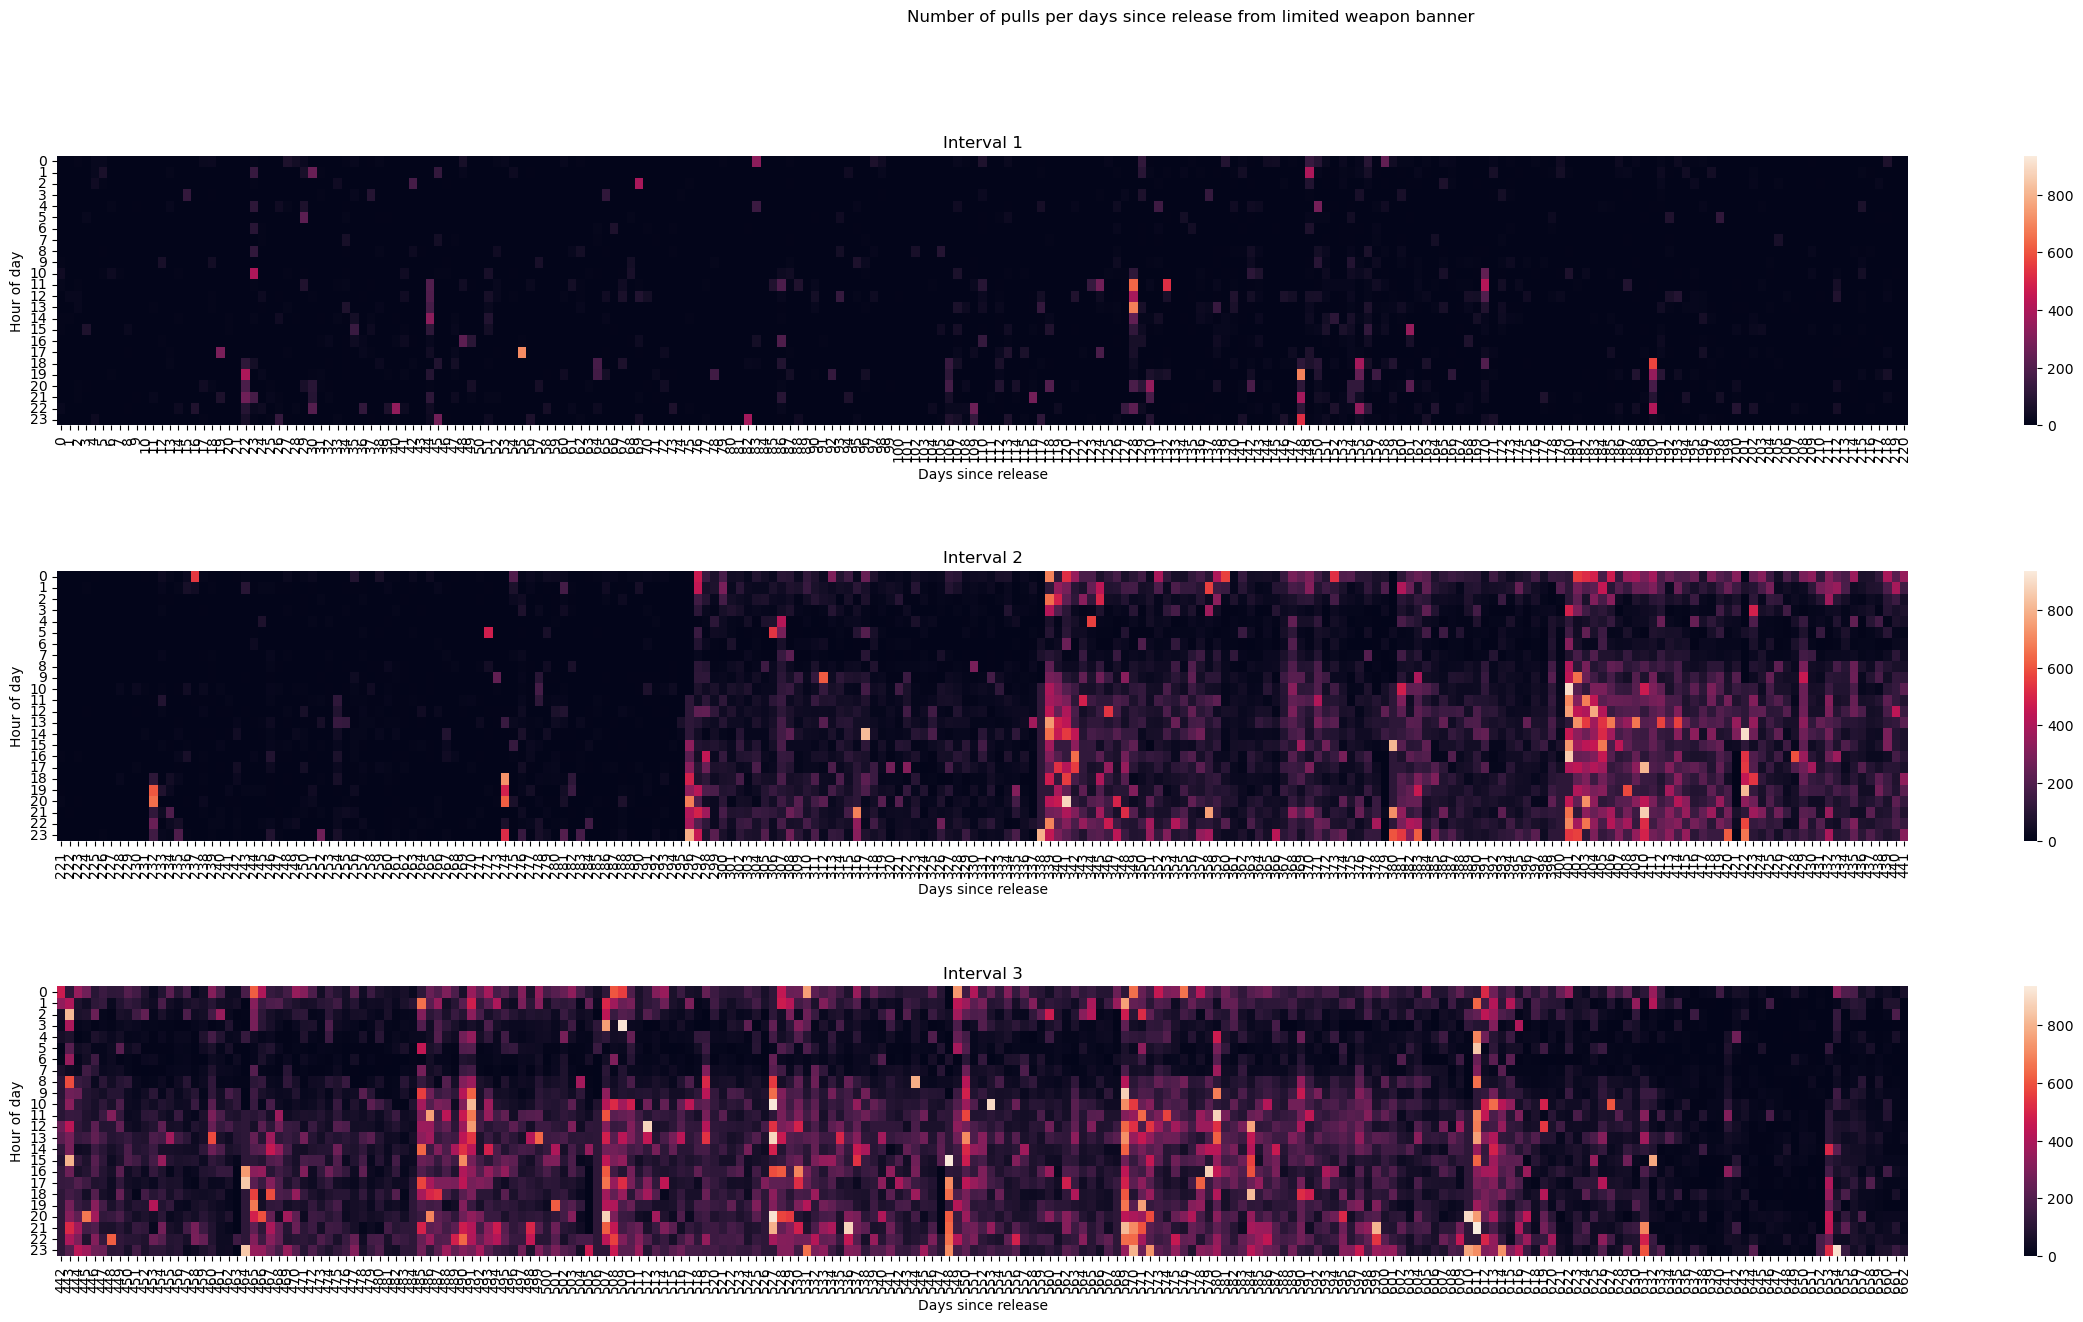

In [30]:
fig, axes = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(weapon_all, axes, interval_name="Interval")
fig.suptitle(
    "Number of pulls per days since release from limited weapon banner")
fig.tight_layout(pad=DSR_PAD)


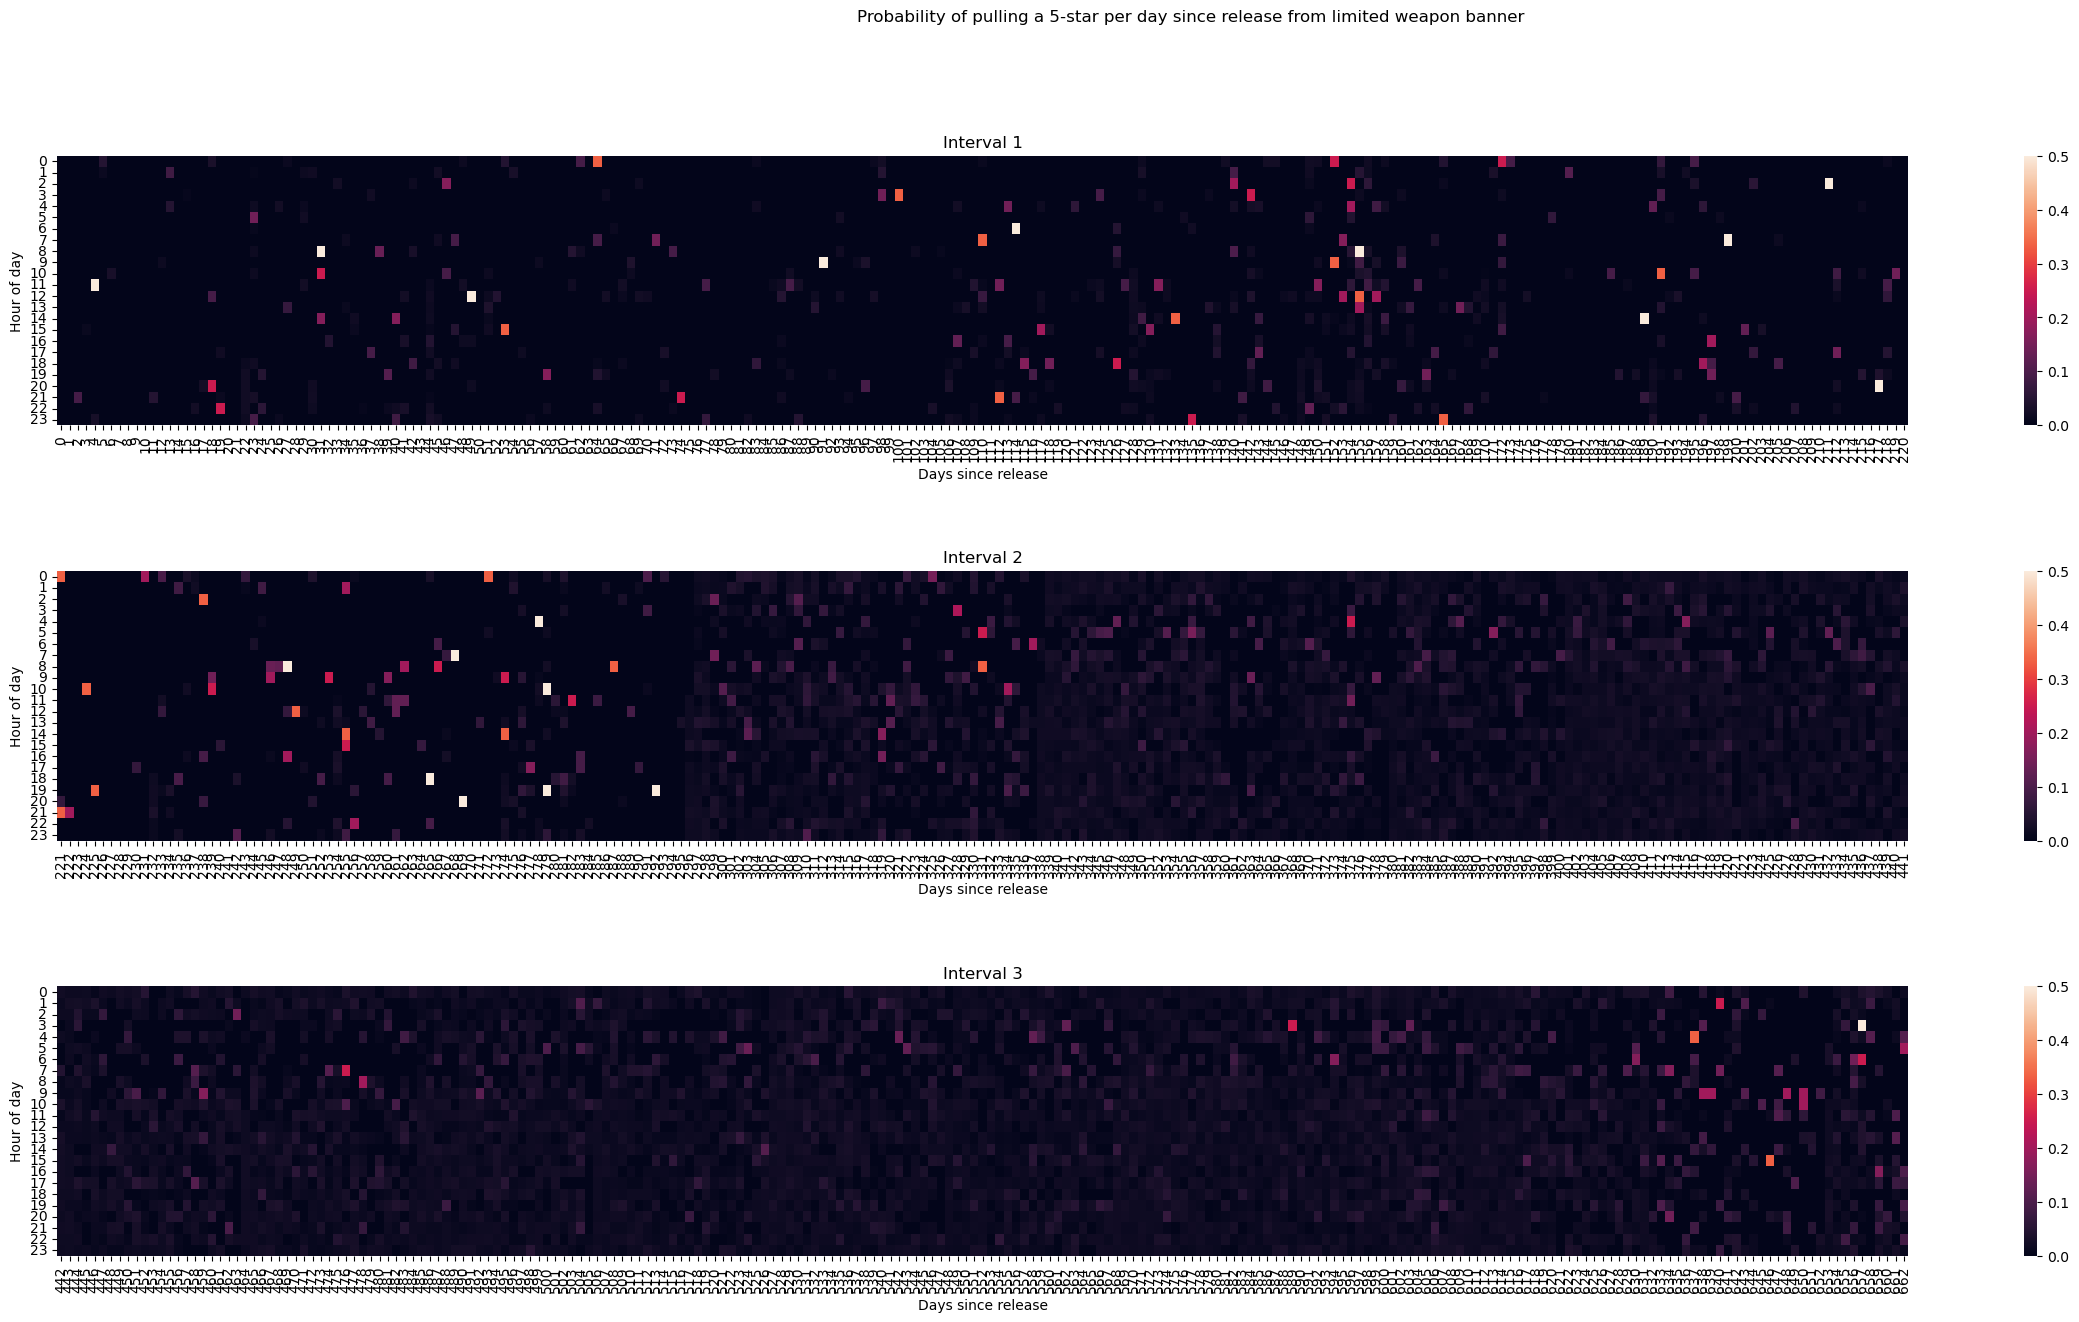

In [31]:
fig, axes = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(weapon_5stars, axes, interval_name="Interval")
fig.suptitle(
    "Probability of pulling a 5-star per day since release from limited weapon banner")
fig.tight_layout(pad=DSR_PAD)


## Observations

After ignoring the outliers in the number of pulls heat map, it is clear to us now that the number of
people making gacha pulls during the early hours of the day is lower than other times. This could be
the reason behind why the probability of getting a good pull is higher during those hour.


# Last Try: _Seems like it's just the time of day now_

So far, we've had a suspicion that there might be a higher likelihood of pulling a 5-star in the earlier
hours of the morning. However, we don't really know which interval is best. Thus, we're going to just
average the probability of


In [32]:
full_dsr = transform_func(full_df, dsr_transformer, (24, DAYS_SINCE_RELEASE))
_, pr_5stars, _ = full_dsr


Text(0, 0.5, 'Prob(5-star)')

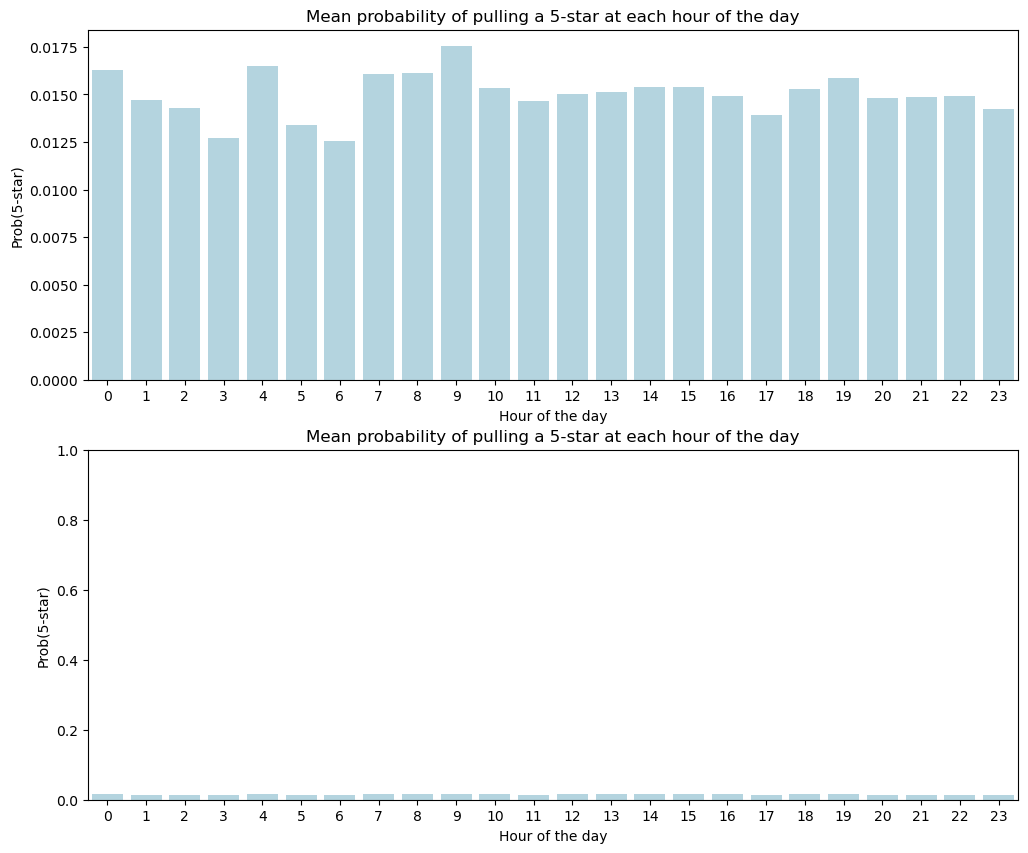

In [33]:
summed_full_dsr = np.mean(pr_5stars, axis=1).T

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10))

sns.barplot(x=np.arange(0, 24), y=summed_full_dsr, ax=ax1, color="lightblue")
ax1.set_title("Mean probability of pulling a 5-star at each hour of the day")
ax1.set_xlabel("Hour of the day")
ax1.set_ylabel("Prob(5-star)")

sns.barplot(x=np.arange(0, 24), y=summed_full_dsr, ax=ax2, color="lightblue")
ax2.set_ylim(0, 1)
ax2.set_title("Mean probability of pulling a 5-star at each hour of the day")
ax2.set_xlabel("Hour of the day")
ax2.set_ylabel("Prob(5-star)")


## Observation

In the upper bar chart, we can see that the drop rate in the early morning seems more volatile and
fluctuated. This could be why the heat map seems _brighter_ since it has higher contrast as well.
Even so, in the grand scheme of things, the difference is not very useful because the difference
of probability is less than 0.01, meaning that no matter when you make a pull, you will most likely
get the same pull results as any other.


# Discussion and Conclusion

After all the analysis so far, we return to our original question: _Is the RNG based on date and time_?
And my answer is going to be _Nope_. From our analysis, the difference of probability is so minute that
no one will benefit from it.

A fancy ML model would also be a waste on this project too since the data appears to show no correlation
between time and probability of getting a good drop, even if 2-10am seems to be the best time to pull
with its slightly _brighter_ heat map.

In conclusion, there is no such a thing as the best time to make a pull. In other words, the best time
to pull is when you have the in-game currency and the banner available contains the character or weapon
that you want.

Thank you for coming along for the journey!
